# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from os.path import join

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss

# 1. Original dataset

Link to dataset download: https://www.kaggle.com/datasets/memocan/data-science-interview-q-and-a-treasury/data

Dataset has been extended with difficulty column derived by the emojies signing the difficulty of the question at the end of the questions. A topic column also has been added classifying each question into nine different topic. The topics has been picked by me.


In [ ]:
data_path = "dataset_6.csv"
df = pd.read_csv(data_path)
df.head()

,question,answer,difficulty,topic
0,What is supervised machine learning?,Supervised learning is a type of machine learn...,beginner,supervised learning
1,What is regression? Which models can you use t...,Regression is a part of supervised ML. Regress...,beginner,supervised learning
2,What is linear regression? When do we use it?,Linear regression is a model that assumes a li...,beginner,supervised learning
3,What are the main assumptions of linear regres...,There are several assumptions of linear regres...,intermediate,supervised learning
4,What’s the normal distribution? Why do we care...,The normal distribution is a continuous probab...,beginner,supervised learning


In [ ]:
df["difficulty"].value_counts()

,count
difficulty,
intermediate,114
beginner,40
advanced,13


In [ ]:
df["topic"].value_counts()

,count
topic,
neural networks,34
feature selection,30
classification,21
unsupervised learning,21
supervised learning,20
text classification,14
regularization,13
recommender systems,7
time series,7


## 1. Tensorflow tokenizer

In [ ]:
corpus = [elm for elm in df.loc[:, 'question']]
corpus[:3]

['What is supervised machine learning?',
 'What is regression? Which models can you use to solve a regression problem?',
 'What is linear regression? When do we use it?']

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)
sequences[0]

[1, 3, 193, 74, 34]

In [ ]:
max_len = max(len(sequence) for sequence in sequences)
max_len

28

In [ ]:
sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
sequences[0]

array([  1,   3, 193,  74,  34,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

### 1. Difficulty classification

In [ ]:
df['difficulty'].value_counts()

,count
difficulty,
intermediate,114
beginner,40
advanced,13


In [ ]:
targets = [elm for elm in df.loc[:, 'difficulty']]
targets[:5]

['beginner', 'beginner', 'beginner', 'intermediate', 'beginner']

In [ ]:
ratings = pd.Categorical(targets)
ratings.codes

array([1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1,
       2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2], dtype=int8)

In [ ]:
targets = to_categorical(ratings.codes)
targets[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
print("Original data: advanced: " + str(len([x for x in y_train if x[0] == 1])) + ", beginner: " + str(len([x for x in y_train if x[1] == 1])) + ", intermediate: " + str(len([x for x in y_train if x[2] == 1])))
print("Oversampled data: advanced: " + str(len([x for x in yTrain_oversampled if x[0] == 1])) + ", beginner: " + str(len([x for x in yTrain_oversampled if x[1] == 1])) + ", intermediate: " + str(len([x for x in yTrain_oversampled if x[2] == 1])))

Original data: advanced: 11, beginner: 34, intermediate: 96
Oversampled data: advanced: 96, beginner: 96, intermediate: 96


#### 1. LSTM

Training of model:

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.3765 - loss: 1.0895 - val_accuracy: 0.0000e+00 - val_loss: 1.4117
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3537 - loss: 1.0773 - val_accuracy: 0.0000e+00 - val_loss: 1.5657
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4575 - loss: 1.0446 - val_accuracy: 0.0000e+00 - val_loss: 1.5240
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5536 - loss: 1.0014 - val_accuracy: 0.0000e+00 - val_loss: 1.1930
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5619 - loss: 0.8107 - val_accuracy: 1.0000 - val_loss: 0.5978
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7461 - loss: 0.5284 - val_accuracy: 0.0000e+00 - val_loss: 1.1306
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7797 - loss: 0.4705 - val_accuracy: 0.0000e+00 - val_loss: 0.7872
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8011 - loss: 0.41

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step

Classification report: 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.44      0.67      0.53         6
           2       0.85      0.61      0.71        18

    accuracy                           0.65        26
   macro avg       0.60      0.76      0.64        26
weighted avg       0.73      0.65      0.67        26

Balanced accuracy:  0.7592592592592592

Confusion matrix: 


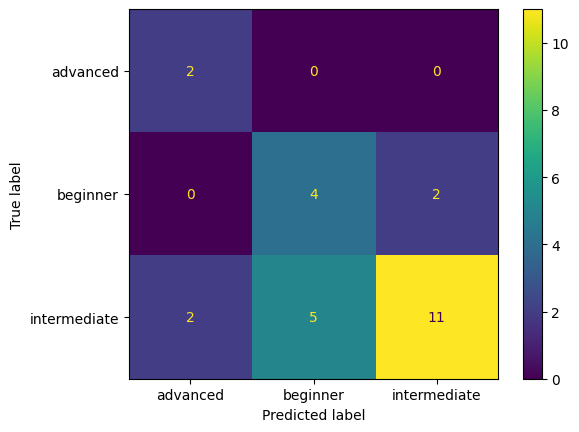

In [ ]:
model = Sequential([
    Embedding(5000, 64),
    LSTM(units=100, dropout=0.1),
    Dense(64, activation='relu'),
    Dense(3, activation=softmax)
])

print("Training of model:")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_lstm.weights.h5")

In [ ]:
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)             │ (None, 28, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,177,979 (4.49 MB)

 Trainable params: 392,659 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 785,320 (3.00 MB)

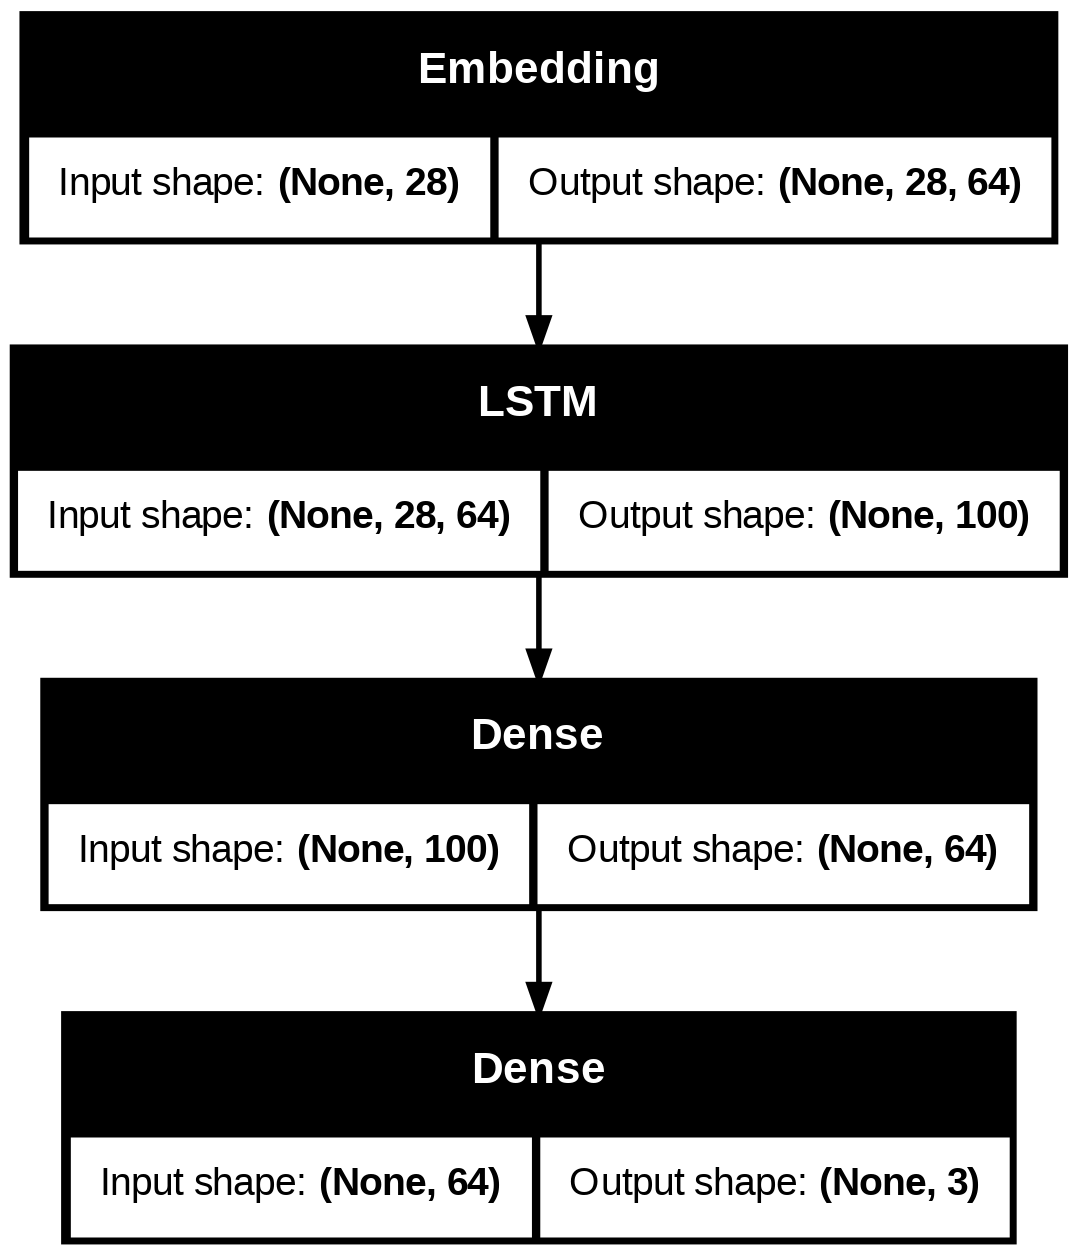

In [ ]:
plot_model(model, show_shapes=True)

#### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(5000, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(3, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

Training on model

Epoch 1/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.4628 - loss: 1.0680 - val_accuracy: 0.0000e+00 - val_loss: 1.2488
Epoch 2/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6993 - loss: 0.7284 - val_accuracy: 0.5227 - val_loss: 0.7830
Epoch 3/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8573 - loss: 0.5289 - val_accuracy: 0.9773 - val_loss: 0.4299
Epoch 4/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9109 - loss: 0.3808 - val_accuracy: 0.9318 - val_loss: 0.4497
Epoch 5/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9164 - loss: 0.3015 - val_accuracy: 0.9773 - val_loss: 0.2779
Epoch 6/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9691 - loss: 0.1514 - val_accuracy: 0.9545 - val_loss: 0.2422
Prediction on test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.60      0.50  

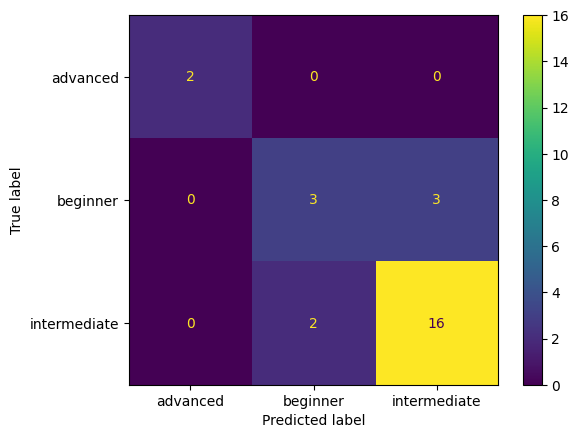

In [ ]:
print("Training on model")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=6, validation_split=0.15)

print("Prediction on test set")
print()
predicted = model.predict(X_test)

x = []
y = []
for i in range(len(predicted)):
    pred_list = np.ndarray.tolist(predicted[i])
    pred_ind = pred_list.index(max(pred_list))
    x.append(pred_ind)
    pred_list = np.ndarray.tolist(y_test[i])
    pred_ind = pred_list.index(max(pred_list))
    y.append(pred_ind)

print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_transformer.weights.h5")

In [ ]:
model.summary()

Model: "transformer_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_45 (Embedding)             │ (None, 28, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_17              │ (None, 28, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_20               │ (None, 28, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_20 (Add)                         │ (None, 28, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_47 (Sequential)           │ (None, 28, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,610,495 (6.14 MB)

 Trainable params: 536,831 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,073,664 (4.10 MB)

### 2. Topic classification

In [ ]:
df['topic'].value_counts()

,count
topic,
neural networks,34
feature selection,30
classification,21
unsupervised learning,21
supervised learning,20
text classification,14
regularization,13
recommender systems,7
time series,7


In [ ]:
targets = [elm for elm in df.loc[:, 'topic']]
targets[:5]

['supervised learning',
 'supervised learning',
 'supervised learning',
 'supervised learning',
 'supervised learning']

In [ ]:
ratings = pd.Categorical(targets)
ratings.codes

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3,
       3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7], dtype=int8)

In [ ]:
targets = to_categorical(ratings.codes)
targets[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

#### 1. LSTM

Training of model:

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.1014 - loss: 2.1943 - val_accuracy: 0.0000e+00 - val_loss: 2.2913
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.1330 - loss: 2.1760 - val_accuracy: 0.0000e+00 - val_loss: 2.4899
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1079 - loss: 2.1501 - val_accuracy: 0.0000e+00 - val_loss: 3.0099
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.1633 - loss: 2.1463 - val_accuracy: 0.0000e+00 - val_loss: 3.0621
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1762 - loss: 2.1193 - val_accuracy: 0.0000e+00 - val_loss: 3.0131
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1699 - loss: 2.1142 - val_accuracy: 0.1316 - val_loss: 2.9812
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1848 - loss: 2.0170 - val_accuracy: 0.1316 - val_loss: 2.3590
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.2827 - loss: 1.8558 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


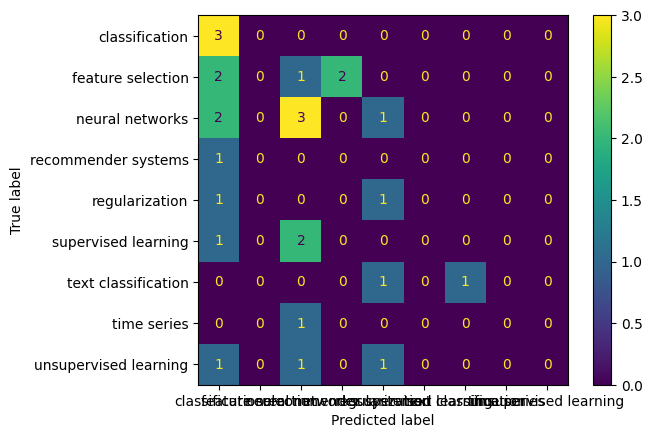

In [ ]:
model = Sequential([
    Embedding(5000, 64),
    LSTM(units=100, dropout=0.1),
    Dense(64, activation='relu'),
    Dense(9, activation=softmax)
])

print("Training of model:")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_lstm.weights.h5")

In [ ]:
model.summary()

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_53 (Embedding)             │ (None, 28, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,179,149 (4.50 MB)

 Trainable params: 393,049 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 786,100 (3.00 MB)

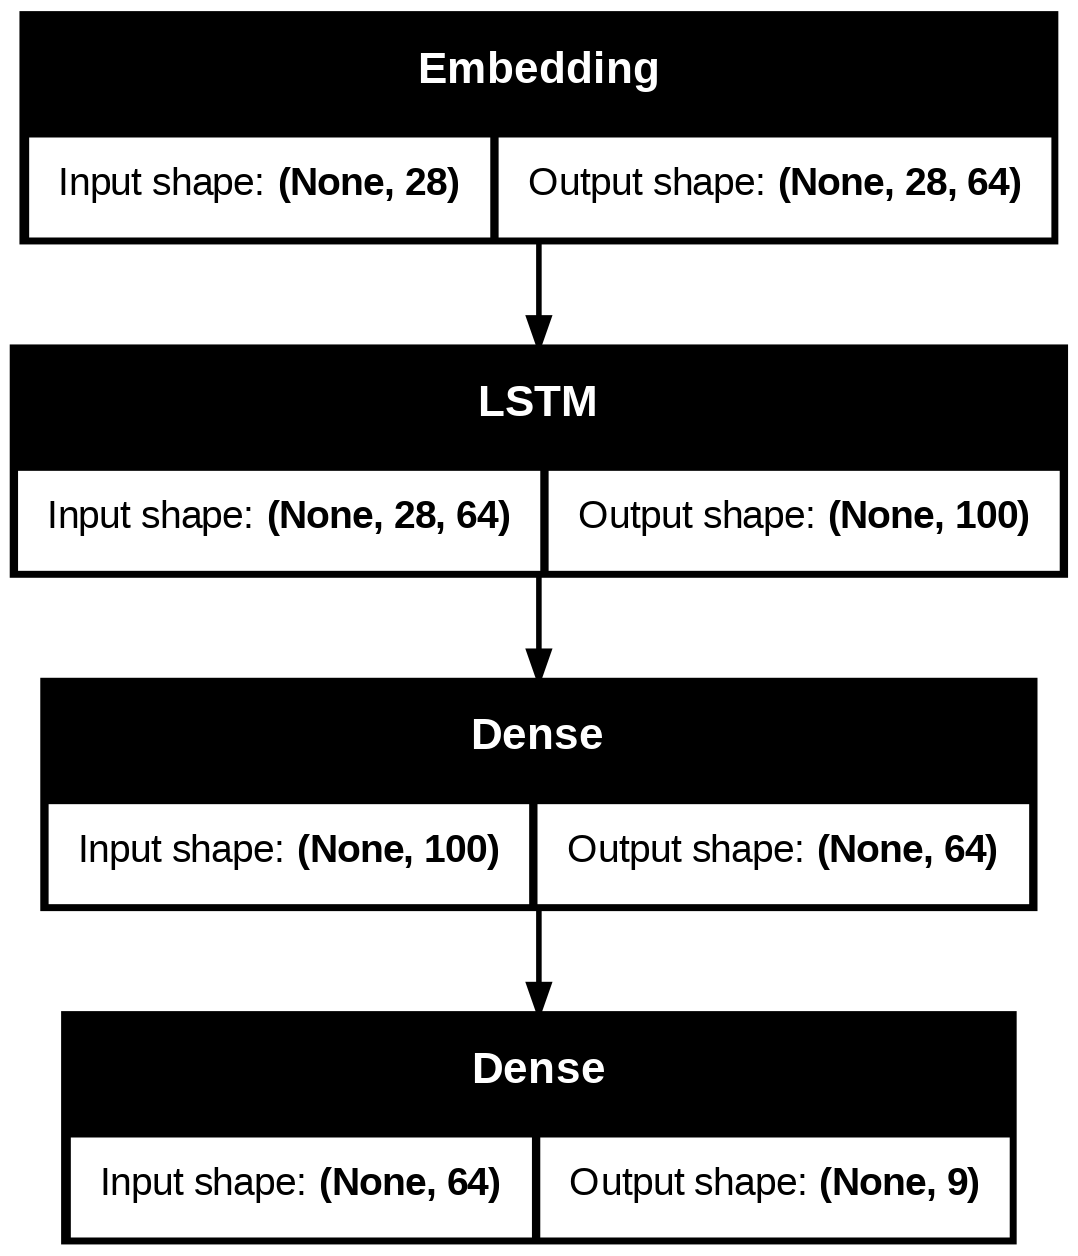

In [ ]:
plot_model(model, show_shapes=True)

#### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(200, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(9, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model:

Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - accuracy: 0.1644 - loss: 2.4030 - val_accuracy: 0.1579 - val_loss: 2.6597
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.5085 - loss: 1.9538 - val_accuracy: 0.0000e+00 - val_loss: 2.7629
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.5360 - loss: 1.7726 - val_accuracy: 0.1316 - val_loss: 2.5901
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5981 - loss: 1.5780 - val_accuracy: 0.0263 - val_loss: 2.3808
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7390 - loss: 1.2379 - val_accuracy: 0.1053 - val_loss: 2.1941
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.7829 - loss: 0.9128 - val_accuracy: 0.3421 - val_loss: 1.7097
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.8999 - loss: 0.5022 - val_accuracy: 0.4211 - val_loss: 1.2821
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9442 - loss: 0.2982 - val_accuracy: 1.

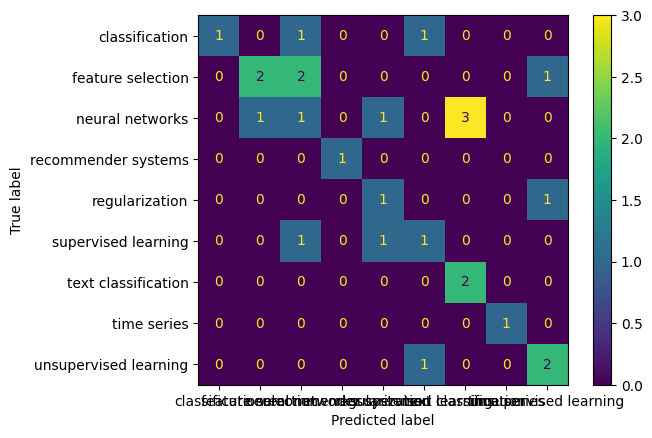

In [ ]:
print("Training of model:")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=8, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_transformer.weights.h5")

In [ ]:
model.summary()

Model: "transformer_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_54 (Embedding)             │ (None, 28, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_18              │ (None, 28, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_21               │ (None, 28, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_21 (Add)                         │ (None, 28, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_56 (Sequential)           │ (None, 28, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,611,665 (6.15 MB)

 Trainable params: 537,221 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,074,444 (4.10 MB)

## 2. Keyword tokenizer

In [ ]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions):
            for caption in captions:
                words = nltk.word_tokenize(caption.lower())
                for word in words:
                    self.add_word(WordNetLemmatizer().lemmatize(word))

In [ ]:
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
vocab = Vocabulary()
vocab.build_vocabulary(list(df['question']))

VOCAB_SIZE = len(vocab.word2idx)
print(f"Vocabulary size: {VOCAB_SIZE}")

for idx in range(vocab.idx):
    print(idx, vocab.idx2word[idx])

Vocabulary size: 339
0 what
1 is
2 supervised
3 machine
4 learning
5 ?
6 regression
7 which
8 model
9 can
10 you
11 use
12 to
13 solve
14 a
15 problem
16 linear
17 when
18 do
19 we
20 it
21 are
22 the
23 main
24 assumption
25 of
26 ’
27 s
28 normal
29 distribution
30 why
31 care
32 about
33 how
34 check
35 if
36 variable
37 follows
38 want
39 build
40 for
41 predicting
42 price
43 distributed
44 normally
45 need
46 any
47 pre-processing
48 method
49 solving
50 know
51 gradient
52 descent
53 doe
54 work
55 equation
56 sgd
57 —
58 stochastic
59 difference
60 with
61 usual
62 metric
63 evaluating
64 mse
65 and
66 rmse
67 bias-variance
68 trade-off
69 overfitting
70 validate
71 your
72 split
73 our
74 data
75 into
76 three
77 part
78 :
79 train
80 ,
81 validation
82 test
83 explain
84 cross-validation
85 k-fold
86 choose
87 k
88 in
89 favorite
90 classification
91 would
92 logistic
93 sigmoid
94 evaluate
95 accuracy
96 always
97 good
98 confusion
99 table
100 cell
101 this
102 precision
10

In [ ]:
word_occurrence = {}
for idx in range(vocab.idx):
    word_occurrence[vocab.idx2word[idx]] = 0

len(word_occurrence)

i = 0
for caption in list(df['question']):
    words = nltk.word_tokenize(caption.lower())
    for word in words:
        new_word = WordNetLemmatizer().lemmatize(word)
        word_occurrence[new_word] = word_occurrence[new_word] + 1

for word, occurrence in word_occurrence.items():
    print(word, occurrence)

what 92
is 61
supervised 1
machine 4
learning 10
? 217
regression 13
which 16
model 34
can 25
you 44
use 27
to 37
solve 4
a 40
problem 15
linear 15
when 20
do 63
we 57
it 34
are 27
the 60
main 5
assumption 1
of 32
’ 16
s 15
normal 3
distribution 2
why 16
care 2
about 2
how 58
check 1
if 10
variable 8
follows 1
want 3
build 1
for 35
predicting 1
price 3
distributed 1
normally 1
need 16
any 6
pre-processing 1
method 1
solving 5
know 21
gradient 14
descent 4
doe 8
work 10
equation 1
sgd 4
— 4
stochastic 2
difference 6
with 11
usual 3
metric 4
evaluating 1
mse 1
and 20
rmse 1
bias-variance 1
trade-off 2
overfitting 1
validate 1
your 3
split 3
our 9
data 7
into 3
three 2
part 1
: 2
train 2
, 10
validation 1
test 1
explain 1
cross-validation 3
k-fold 2
choose 3
k 5
in 22
favorite 1
classification 13
would 12
logistic 4
sigmoid 3
evaluate 2
accuracy 2
always 1
good 3
confusion 1
table 2
cell 1
this 2
precision 3
recall 2
f1-score 1
precision-recall 2
roc 4
curve 3
auc 1
( 5
au 4
) 5
interpret

In [ ]:
nltk.download('stopwords')

word_occurrence_no_stopwords = {}
for k, v in word_occurrence.items():
    if any(c.isalpha() for c in k) and len(k) > 1 and k not in stopwords.words('english'):
      word_occurrence_no_stopwords[k] = v
print(len(word_occurrence_no_stopwords), len(word_occurrence))

264 339


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sorted_tokens = sorted(word_occurrence_no_stopwords.items(), key=lambda x: x[1], reverse=True)
sorted_tokens = [('<PAD>', 0)] + sorted_tokens
for x in sorted_tokens:
    print(x)

('<PAD>', 0)
('model', 34)
('use', 27)
('know', 21)
('need', 16)
('tree', 16)
('problem', 15)
('linear', 15)
('gradient', 14)
('regression', 13)
('classification', 13)
('would', 12)
('regularization', 12)
('feature', 12)
('learning', 10)
('work', 10)
('boosting', 10)
('neural', 10)
('random', 9)
('training', 9)
('text', 9)
('word', 9)
('variable', 8)
('doe', 8)
('data', 7)
('technique', 7)
('forest', 7)
('net', 7)
('series', 7)
('difference', 6)
('select', 6)
('parameter', 6)
('decision', 6)
('approach', 6)
('ranking', 6)
('time', 6)
('main', 5)
('solving', 5)
('happens', 5)
('l2', 5)
('weight', 5)
('selection', 5)
('bag', 5)
('algorithm', 5)
('machine', 4)
('solve', 4)
('descent', 4)
('sgd', 4)
('metric', 4)
('logistic', 4)
('roc', 4)
('au', 4)
('useful', 4)
('kind', 4)
('l1', 4)
('one', 4)
('possible', 4)
('search', 4)
('rate', 4)
('cnn', 4)
('embeddings', 4)
('normal', 3)
('want', 3)
('price', 3)
('usual', 3)
('split', 3)
('cross-validation', 3)
('choose', 3)
('sigmoid', 3)
('good',

In [ ]:
word2idx = {}
idx2word = {}
idx = 0
with open("keywords.txt") as file:
    #for word, occurence in sorted_tokens:
    for line in file:
        line = line.rstrip()
        word = line.split(' ')[0]
        word2idx[word] = idx
        idx2word[idx] = word
        idx = idx + 1

print(len(sorted_tokens), len(word2idx))
for idx, word in idx2word.items():
    print(idx, word)

265 198
0 <PAD>
1 model
2 tree
3 problem
4 linear
5 gradient
6 regression
7 classification
8 regularization
9 feature
10 learning
11 boosting
12 neural
13 random
14 training
15 text
16 word
17 variable
18 data
19 technique
20 forest
21 net
22 series
23 difference
24 select
25 parameter
26 decision
27 approach
28 ranking
29 time
30 main
31 solving
32 l2
33 weight
34 selection
35 bag
36 algorithm
37 machine
38 solve
39 descent
40 sgd
41 metric
42 logistic
43 roc
44 au
45 l1
46 search
47 rate
48 cnn
49 embeddings
50 normal
51 split
52 cross-validation
53 sigmoid
54 precision
55 curve
56 pr
57 dimensionality
58 column
59 large
60 tuning
61 network
62 set
63 adam
64 pooling
65 augmentation
66 architecture
67 k-means
68 recommender
69 system
70 cold
71 start
72 distribution
73 stochastic
74 trade-off
75 train
76 k-fold
77 evaluate
78 accuracy
79 table
80 recall
81 precision-recall
82 interpret
83 categorical
84 curse
85 sum
86 parallelize
87 importance
88 strategy
89 fully-connected
90 activ

In [ ]:
key_vectors = []
vec_len = 10
for text in list(df['question']):
  vec_rep = []
  words = nltk.word_tokenize(text.lower())
  keywords = []
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        keywords.append(new_word)
        vec_rep.append(word2idx[new_word])
  if len(vec_rep) >= vec_len:
    vec_rep = vec_rep[:vec_len]
  else:
    vec_rep = vec_rep + [0 for x in range(vec_len - len(vec_rep))]
  print(keywords)
  print(len(vec_rep), vec_rep)
  vec_rep = np.array(vec_rep)
  key_vectors.append(vec_rep)
key_vectors = np.array(key_vectors)

['supervised', 'machine', 'learning']
10 [102, 37, 10, 0, 0, 0, 0, 0, 0, 0]
['regression', 'model', 'solve', 'regression', 'problem']
10 [6, 1, 38, 6, 3, 0, 0, 0, 0, 0]
['linear', 'regression']
10 [4, 6, 0, 0, 0, 0, 0, 0, 0, 0]
['main', 'assumption', 'linear', 'regression']
10 [30, 103, 4, 6, 0, 0, 0, 0, 0, 0]
['normal', 'distribution']
10 [50, 72, 0, 0, 0, 0, 0, 0, 0, 0]
['variable', 'normal', 'distribution']
10 [17, 50, 72, 0, 0, 0, 0, 0, 0, 0]
['build', 'model', 'predicting', 'distributed', 'normally', 'pre-processing']
10 [104, 1, 105, 106, 107, 108, 0, 0, 0, 0]
['method', 'solving', 'linear', 'regression']
10 [109, 31, 4, 6, 0, 0, 0, 0, 0, 0]
['gradient', 'descent']
10 [5, 39, 0, 0, 0, 0, 0, 0, 0, 0]
['normal', 'equation']
10 [50, 110, 0, 0, 0, 0, 0, 0, 0, 0]
['sgd', 'stochastic', 'gradient', 'descent', 'difference', 'gradient', 'descent']
10 [40, 73, 5, 39, 23, 5, 39, 0, 0, 0]
['metric', 'evaluating', 'regression', 'model']
10 [41, 111, 6, 1, 0, 0, 0, 0, 0, 0]
['mse', 'rmse']
10 

In [ ]:
key_vectors

array([[102,  37,  10, ...,   0,   0,   0],
       [  6,   1,  38, ...,   0,   0,   0],
       [  4,   6,   0, ...,   0,   0,   0],
       ...,
       [ 22,  17,  29, ...,   0,   0,   0],
       [ 22,  17,  62, ...,   0,   0,   0],
       [  3,   2,  31, ...,   0,   0,   0]])

### 1. Difficulty classification

In [ ]:
df['difficulty'].value_counts()

,count
difficulty,
intermediate,114
beginner,40
advanced,13


In [ ]:
targets = [elm for elm in df.loc[:, 'difficulty']]
targets[:5]

['beginner', 'beginner', 'beginner', 'intermediate', 'beginner']

In [ ]:
ratings = pd.Categorical(targets)
ratings.codes

array([1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1,
       2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2], dtype=int8)

In [ ]:
targets = to_categorical(ratings.codes)
targets[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(key_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

#### 1. LSTM

Training of model:

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.4166 - loss: 1.0903 - val_accuracy: 0.0000e+00 - val_loss: 1.3471
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4499 - loss: 1.0621 - val_accuracy: 0.0000e+00 - val_loss: 1.4406
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5701 - loss: 1.0222 - val_accuracy: 0.0000e+00 - val_loss: 1.3439
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7262 - loss: 0.8370 - val_accuracy: 0.0000e+00 - val_loss: 1.2465
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7179 - loss: 0.6237 - val_accuracy: 0.0000e+00 - val_loss: 0.9795
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7692 - loss: 0.5466 - val_accuracy: 0.0000e+00 - val_loss: 1.0174
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7559 - loss: 0.5000 - val_accuracy: 0.1136 - val_loss: 0.9419
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8187 - loss: 0.45

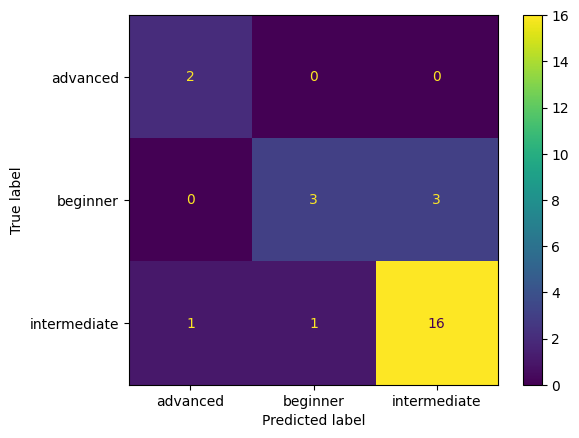

In [ ]:
print("Training of model:")
print()
model = Sequential([
    Embedding(200, 64),
    LSTM(units=100, dropout=0.1),
    Dense(64, activation='relu'),
    Dense(3, activation=softmax)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_lstm_keyword.weights.h5")

In [ ]:
model.summary()

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_59 (Embedding)             │ (None, 10, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,177,979 (4.49 MB)

 Trainable params: 392,659 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 785,320 (3.00 MB)

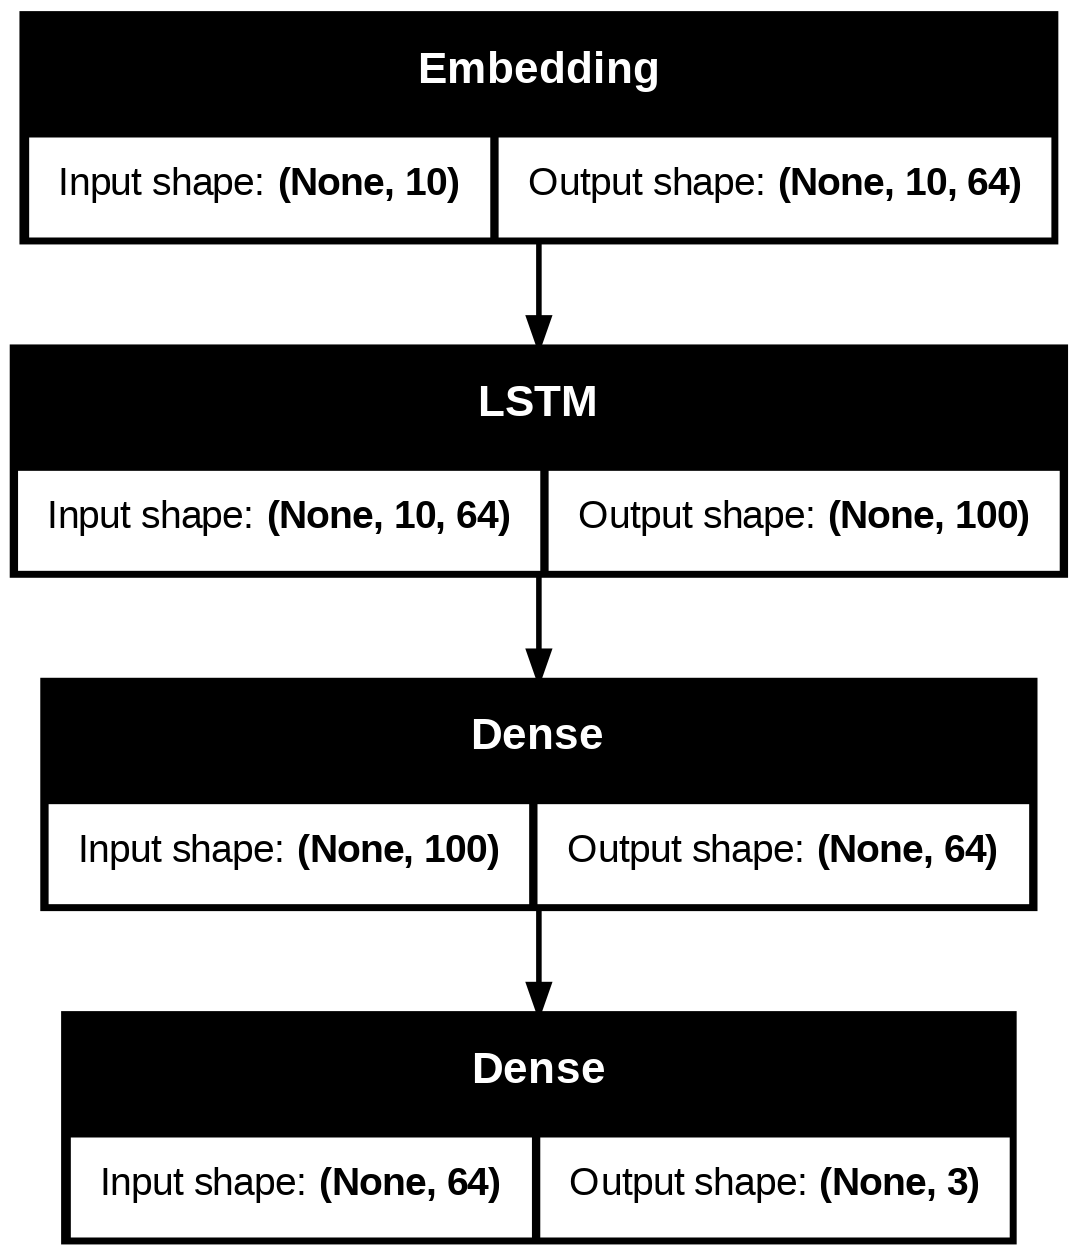

In [ ]:
plot_model(model, show_shapes=True)

#### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(5000, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(3, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model:

Epoch 1/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.4660 - loss: 1.2004 - val_accuracy: 0.0000e+00 - val_loss: 1.3244
Epoch 2/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6635 - loss: 0.7644 - val_accuracy: 0.3182 - val_loss: 1.1393
Epoch 3/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7653 - loss: 0.5780 - val_accuracy: 0.9091 - val_loss: 0.5086
Epoch 4/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8092 - loss: 0.4872 - val_accuracy: 0.8182 - val_loss: 0.6197
Epoch 5/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8826 - loss: 0.3396 - val_accuracy: 0.6364 - val_loss: 0.7865
Epoch 6/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9312 - loss: 0.2450 - val_accuracy: 1.0000 - val_loss: 0.1988

Prediction on test set
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step

Classification report: 
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       0.62      0.83 

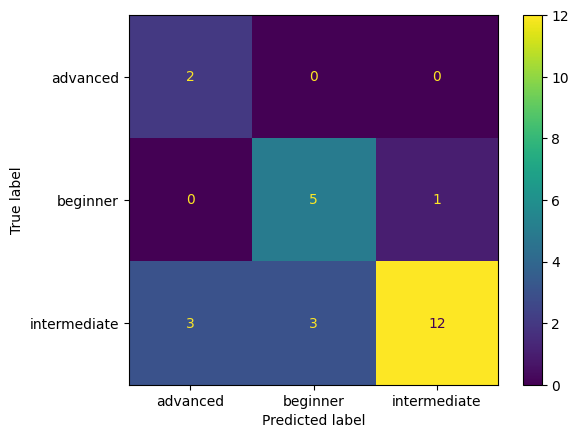

In [ ]:
print("Training of model:")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=6, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_transformer_keyword.weights.h5")

In [ ]:
model.summary()

Model: "transformer_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_67 (Embedding)             │ (None, 10, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_24              │ (None, 10, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_27               │ (None, 10, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_27 (Add)                         │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_69 (Sequential)           │ (None, 10, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_184 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_185 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,610,495 (6.14 MB)

 Trainable params: 536,831 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,073,664 (4.10 MB)

### 2. Topic classification

In [ ]:
df['topic'].value_counts()

,count
topic,
neural networks,34
feature selection,30
classification,21
unsupervised learning,21
supervised learning,20
text classification,14
regularization,13
recommender systems,7
time series,7


In [ ]:
targets = [elm for elm in df.loc[:, 'topic']]
targets[:5]

['supervised learning',
 'supervised learning',
 'supervised learning',
 'supervised learning',
 'supervised learning']

In [ ]:
ratings = pd.Categorical(targets)
ratings.codes

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3,
       3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7], dtype=int8)

In [ ]:
targets = to_categorical(ratings.codes)
targets[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(key_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

#### 1. LSTM

Training of model:

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.0920 - loss: 2.1924 - val_accuracy: 0.0000e+00 - val_loss: 2.3067
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1507 - loss: 2.1711 - val_accuracy: 0.0000e+00 - val_loss: 2.4719
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1251 - loss: 2.1495 - val_accuracy: 0.0000e+00 - val_loss: 2.7320
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1563 - loss: 2.1281 - val_accuracy: 0.0000e+00 - val_loss: 2.9394
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2518 - loss: 2.0475 - val_accuracy: 0.0000e+00 - val_loss: 3.0987
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3347 - loss: 1.9237 - val_accuracy: 0.0000e+00 - val_loss: 2.8273
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4756 - loss: 1.6196 - val_accuracy: 0.0526 - val_loss: 2.8297
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6406 - loss: 1.23

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


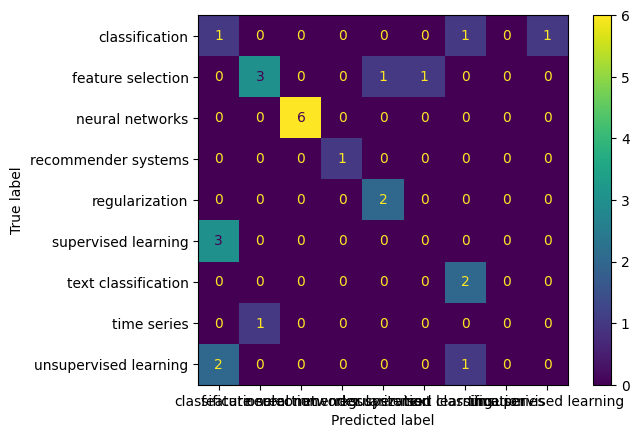

In [ ]:
print("Training of model:")
print()
model = Sequential([
    Embedding(200, 64),
    LSTM(units=100, dropout=0.1),
    Dense(64, activation='relu'),
    Dense(9, activation=softmax)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_lstm_keyword.weights.h5")

In [ ]:
model.summary()

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_71 (Embedding)             │ (None, 10, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_48 (LSTM)                       │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_192 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_193 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,179,149 (4.50 MB)

 Trainable params: 393,049 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 786,100 (3.00 MB)

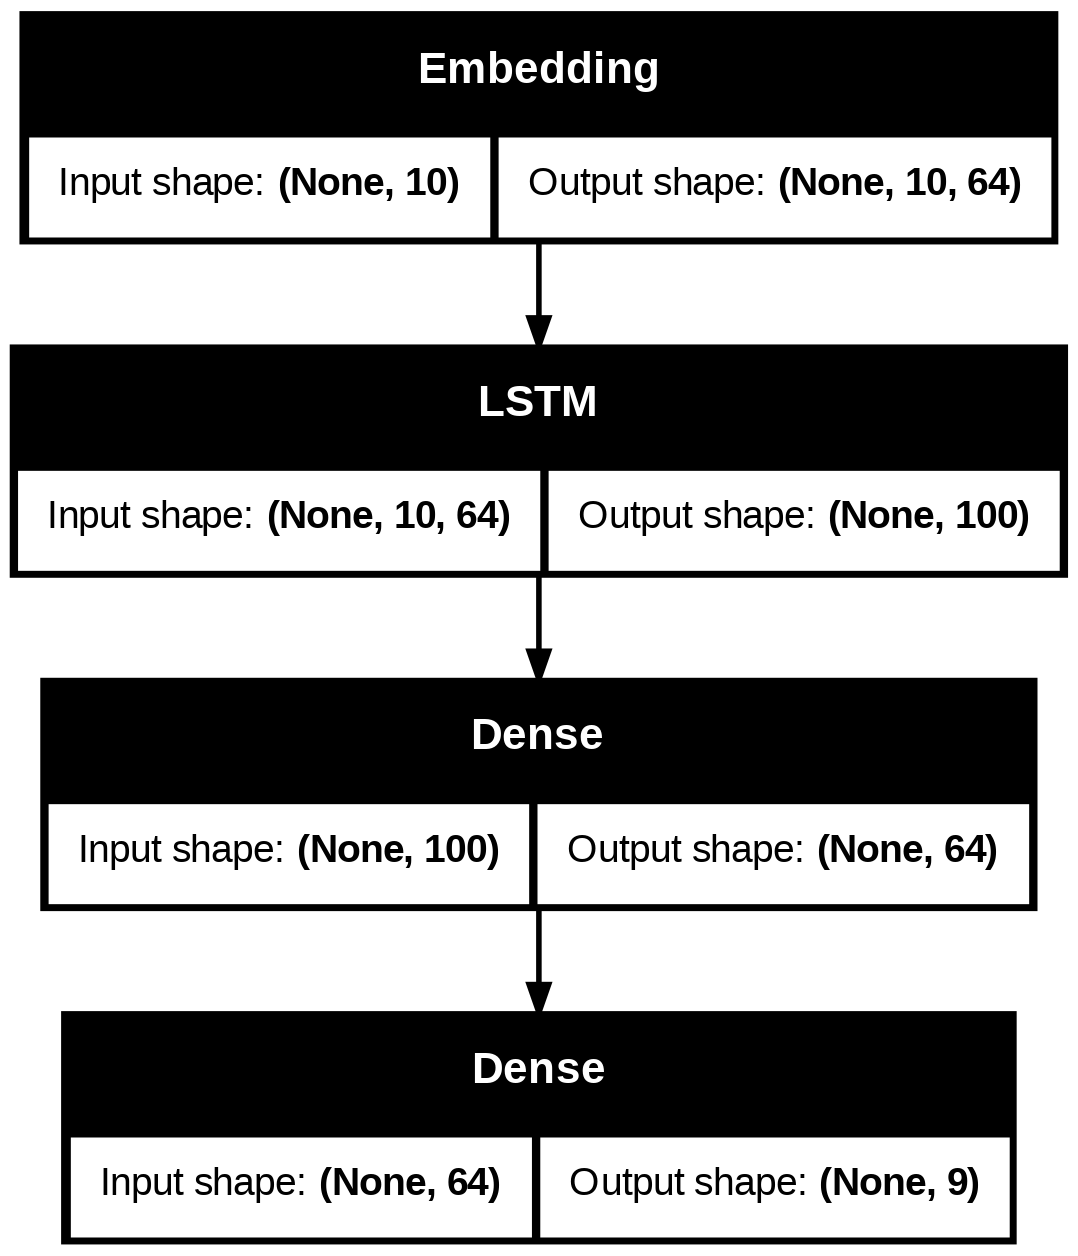

In [ ]:
plot_model(model, show_shapes=True)

#### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(200, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(9, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model:

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.1096 - loss: 2.4587 - val_accuracy: 0.0000e+00 - val_loss: 2.4721
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3515 - loss: 1.8571 - val_accuracy: 0.3947 - val_loss: 1.9986
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7417 - loss: 1.5793 - val_accuracy: 0.1579 - val_loss: 2.1693
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7753 - loss: 1.3434 - val_accuracy: 0.6316 - val_loss: 1.6171
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8809 - loss: 1.0339 - val_accuracy: 0.6579 - val_loss: 1.2827
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9392 - loss: 0.6760 - val_accuracy: 0.8947 - val_loss: 0.9735
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9570 - loss: 0.3860 - val_accuracy: 1.0000 - val_loss: 0.2695
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9820 - loss: 0.1585 - val_accuracy: 1

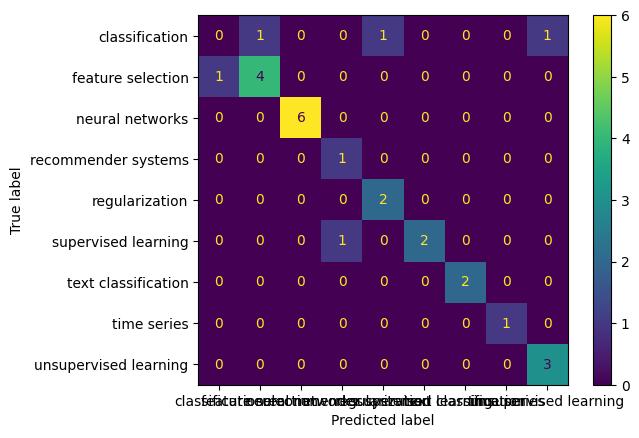

In [ ]:
print("Training of model:")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_transformer_keyword.weights.h5")

In [ ]:
model.summary()

Model: "transformer_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_75 (Embedding)             │ (None, 10, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_26              │ (None, 10, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_29               │ (None, 10, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_29 (Add)                         │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_77 (Sequential)           │ (None, 10, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_204 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_205 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,611,665 (6.15 MB)

 Trainable params: 537,221 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,074,444 (4.10 MB)

## 3. Bag of words from keywords

In [ ]:
bag_vectors = []
for text in list(df['question']):
  bag_vec = [0 for x in word2idx]
  words = nltk.word_tokenize(text.lower())
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        bag_vec[word2idx[new_word]] = bag_vec[word2idx[new_word]] + 1
  bag_vec = np.array(bag_vec)
  bag_vectors.append(bag_vec)
bag_vectors = np.array(bag_vectors)
print(bag_vectors.shape)
bag_vectors

(167, 198)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
bag_vectors[40]

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 1. Difficulty classification

In [ ]:
df['difficulty'].value_counts()

,count
difficulty,
intermediate,114
beginner,40
advanced,13


In [ ]:
targets = [elm for elm in df.loc[:, 'difficulty']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bag_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

#### 1. LSTM

Training of model:

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.4085 - loss: 1.0950 - val_accuracy: 0.0000e+00 - val_loss: 1.1936
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.3896 - loss: 1.0818 - val_accuracy: 0.0000e+00 - val_loss: 1.2937
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3813 - loss: 1.0746 - val_accuracy: 0.0000e+00 - val_loss: 1.4106
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3911 - loss: 1.0716 - val_accuracy: 0.0000e+00 - val_loss: 1.5155
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.3889 - loss: 1.0815 - val_accuracy: 0.0000e+00 - val_loss: 1.5238
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.4139 - loss: 1.0768 - val_accuracy: 0.0000e+00 - val_loss: 1.5602
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.3879 - loss: 1.0615 - val_accuracy: 0.0000e+00 - val_loss: 1.5849
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4066 - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


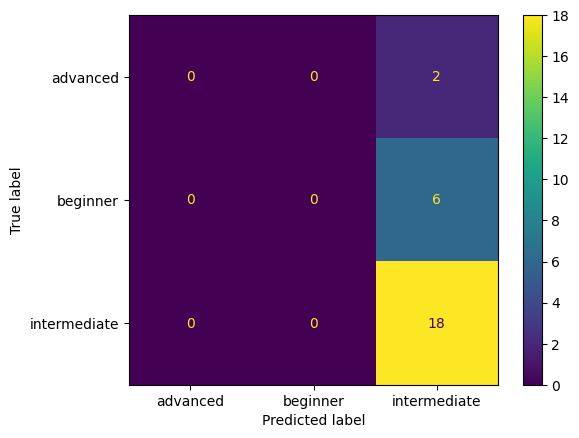

In [ ]:
print("Training of model:")
print()
model = Sequential([
    Embedding(200, 64),
    LSTM(units=10, dropout=0.1),
    Dense(64, activation='relu'),
    Dense(3, activation=softmax)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
print("Prediction on test set")
predicted = model.predict(X_test)
s = 0
i = 0
for pred in predicted:
  pred_list = np.ndarray.tolist(pred)
  print(pred_list)
  pred_ind = pred_list.index(max(pred_list))
  if 1 == y_test[i][pred_ind]:
    s = s + 1
  i = i + 1
accuracy = s / len(y_test)
# test accuracy
print("Test accuracy:", accuracy)

Prediction on test set
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.39370426535606384, 0.210924431681633, 0.3953711986541748]
[0.3937043845653534, 0.21092437207698822, 0.3953711986541748]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.393704354763031, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711986541748]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.3937043845653534, 0.21092437207698822, 0.3953711688518524]
[0.38976666

In [ ]:
print("Original data: advanced: " + str(len([x for x in y_test if x[0] == 1])) + ", beginner: " + str(len([x for x in y_test if x[1] == 1])) + ", intermediate: " + str(len([x for x in y_test if x[2] == 1])))

Original data: advanced: 2, beginner: 6, intermediate: 18


In [ ]:
18/(18+2+6)

0.6923076923076923

#### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(200, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(3, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model:

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3659 - loss: 1.2532 - val_accuracy: 0.0000e+00 - val_loss: 1.3696
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4499 - loss: 1.0752 - val_accuracy: 0.0000e+00 - val_loss: 1.7935
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4082 - loss: 1.0824 - val_accuracy: 0.0000e+00 - val_loss: 1.6346
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3904 - loss: 1.0733 - val_accuracy: 0.0000e+00 - val_loss: 1.4304
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3834 - loss: 1.0656 - val_accuracy: 0.0000e+00 - val_loss: 1.5979

Prediction on test set
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step

Classification report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.69      1.00      0.82        18

    accuracy                           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


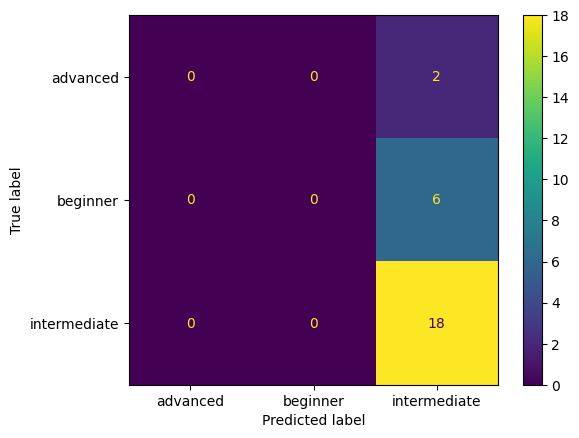

In [ ]:
print("Training of model:")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=5, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
print("Prediction on test set")
predicted = model.predict(X_test)
s = 0
i = 0
for pred in predicted:
  pred_list = np.ndarray.tolist(pred)
  print(pred_list)
  pred_ind = pred_list.index(max(pred_list))
  if 1 == y_test[i][pred_ind]:
    s = s + 1
  i = i + 1
accuracy = s / len(y_test)
# test accuracy
print("Test accuracy:", accuracy)

Prediction on test set
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
[0.35209041833877563, 0.21000978350639343, 0.43789970874786377]
[0.39323022961616516, 0.17540347576141357, 0.4313662350177765]
[0.3662931025028229, 0.1984165459871292, 0.4352903366088867]
[0.3759555518627167, 0.1898690164089203, 0.43417543172836304]
[0.3932304084300995, 0.17540329694747925, 0.4313661754131317]
[0.3759554922580719, 0.1898689866065979, 0.4341755211353302]
[0.35209038853645325, 0.21000978350639343, 0.43789970874786377]
[0.3709750473499298, 0.19409725069999695, 0.434927761554718]
[0.3806045651435852, 0.18593701720237732, 0.43345847725868225]
[0.3593892455101013, 0.20391152799129486, 0.4366992115974426]
[0.3593893051147461, 0.20391131937503815, 0.4366993308067322]
[0.3520904779434204, 0.21000975370407104, 0.43789976835250854]
[0.35369986295700073, 0.20932844281196594, 0.43697166442871094]
[0.37671059370040894, 0.18957927823066711, 0.4337100386619568]
[0.35938936471939087, 0.20391136407852173, 0.4366992712020874]


#### 3. Feedforward network

Training of model:

Epoch 1/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4362 - loss: 1.0749 - val_accuracy: 0.1591 - val_loss: 1.1233
Epoch 2/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6432 - loss: 0.9957 - val_accuracy: 0.1818 - val_loss: 1.1547
Epoch 3/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6786 - loss: 0.9314 - val_accuracy: 0.2045 - val_loss: 1.1646
Epoch 4/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7455 - loss: 0.8707 - val_accuracy: 0.1591 - val_loss: 1.1754
Epoch 5/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8130 - loss: 0.7866 - val_accuracy: 0.1591 - val_loss: 1.1773
Epoch 6/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8337 - loss: 0.7479 - val_accuracy: 0.1818 - val_loss: 1.1627
Epoch 7/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8454 - loss: 0.6802 - val_accuracy: 0.1818 - val_loss: 1.1413
Epoch 8/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8414 - loss: 0.6391 - val_accuracy: 0.1818 - val_l

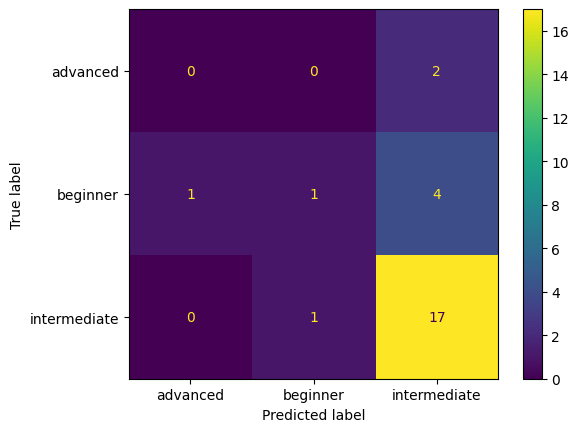

In [ ]:
print("Training of model:")
print()
model = Sequential([
    Dense(100, activation='relu'),
    Dense(3, activation=softmax)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=8, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
print("Prediction on test set")
predicted = model.predict(X_test)
s = 0
i = 0
for pred in predicted:
  pred_list = np.ndarray.tolist(pred)
  print(pred_list)
  pred_ind = pred_list.index(max(pred_list))
  if 1 == y_test[i][pred_ind]:
    s = s + 1
  i = i + 1
accuracy = s / len(y_test)
# test accuracy
print("Test accuracy:", accuracy)

Prediction on test set
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[0.4754698574542999, 0.2726489305496216, 0.25188127160072327]
[0.46448656916618347, 0.15938909351825714, 0.3761243522167206]
[0.264205664396286, 0.19099971652030945, 0.5447946190834045]
[0.1552484929561615, 0.19333240389823914, 0.6514190435409546]
[0.1603766232728958, 0.23227743804454803, 0.6073458194732666]
[0.19800804555416107, 0.2192668914794922, 0.5827251076698303]
[0.15389569103717804, 0.37676379084587097, 0.4693404734134674]
[0.284837543964386, 0.22260044515132904, 0.49256202578544617]
[0.29049673676490784, 0.21000678837299347, 0.4994964599609375]
[0.21684983372688293, 0.15976294875144958, 0.6233871579170227]
[0.4655250608921051, 0.20776817202568054, 0.32670679688453674]
[0.18460305035114288, 0.14604374766349792, 0.6693532466888428]
[0.5847283005714417, 0.1605982631444931, 0.25467345118522644]
[0.3500117361545563, 0.24714826047420502, 0.4028399884700775]
[0.26750048995018005, 0.3557601273059845, 0.3767392635345459]
[0.3

In [ ]:
model.save_weights("difficulty_pred_model_ff_bow.weights.h5")

In [ ]:
model.summary()

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_262 (Dense)                    │ (None, 100)                 │          19,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_263 (Dense)                    │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,611 (236.77 KB)

 Trainable params: 20,203 (78.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,408 (157.85 KB)

### 2. Topic classification

In [ ]:
df['topic'].value_counts()

,count
topic,
neural networks,34
feature selection,30
classification,21
unsupervised learning,21
supervised learning,20
text classification,14
regularization,13
recommender systems,7
time series,7


In [ ]:
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

In [ ]:
train, X_test, y_train, y_test = train_test_split(bag_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

#### 1. Feedforward network

Training of model:

Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.1056 - loss: 2.1934 - val_accuracy: 0.1316 - val_loss: 2.1915
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2614 - loss: 2.1391 - val_accuracy: 0.1053 - val_loss: 2.1870
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3549 - loss: 2.0937 - val_accuracy: 0.1316 - val_loss: 2.1773
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3948 - loss: 2.0412 - val_accuracy: 0.1316 - val_loss: 2.1698
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4743 - loss: 1.9898 - val_accuracy: 0.1579 - val_loss: 2.1686
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5448 - loss: 1.9389 - val_accuracy: 0.2105 - val_loss: 2.1579
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5944 - loss: 1.8885 - val_accuracy: 0.1842 - val_loss: 2.1480
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6733 - loss: 1.8241 - val_accuracy: 0.1842 - val_l

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


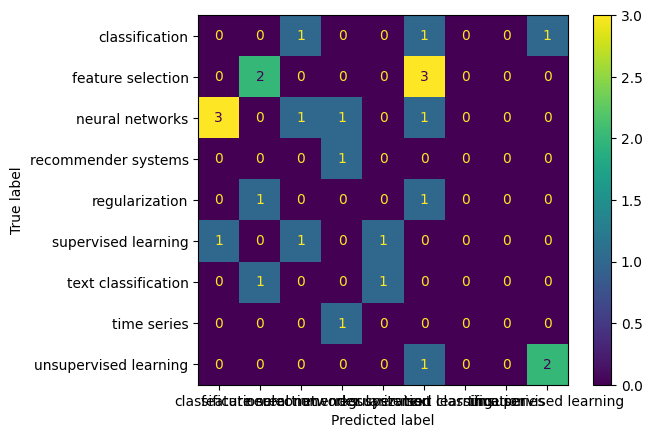

In [ ]:
print("Training of model:")
print()
model = Sequential([
    Dense(100, activation='relu'),
    Dense(9, activation=softmax)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=8, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_ff_bow.weights.h5")

In [ ]:
model.summary()

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_268 (Dense)                    │ (None, 100)                 │          19,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_269 (Dense)                    │ (None, 9)                   │             909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,429 (243.87 KB)

 Trainable params: 20,809 (81.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,620 (162.58 KB)

## 4. TF-IDF

In [ ]:
num_of_features = 5000
corpus = [elm for elm in df.loc[:, 'question']]
corpus = [doc.lower() for doc in corpus]

In [ ]:
class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

In [ ]:
stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=2, max_features=num_of_features, stop_words='english')
bows = tfidf_vectorizer_stemming.fit_transform(corpus)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

### 1. Difficulty classification

In [ ]:
targets = [elm for elm in df.loc[:, 'difficulty']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bows, targets, test_size=0.15, stratify=targets, shuffle=True)

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.5994903 , 0.        , 0.62912185,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

#### 1. Feedforward network

Training of model:

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4238 - loss: 1.0934 - val_accuracy: 0.2955 - val_loss: 1.1206
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5340 - loss: 1.0582 - val_accuracy: 0.0455 - val_loss: 1.1458
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6398 - loss: 1.0143 - val_accuracy: 0.0227 - val_loss: 1.1626
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6395 - loss: 0.9877 - val_accuracy: 0.0000e+00 - val_loss: 1.1727
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6856 - loss: 0.9424 - val_accuracy: 0.0000e+00 - val_loss: 1.1827
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6981 - loss: 0.9157 - val_accuracy: 0.0000e+00 - val_loss: 1.1855
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7369 - loss: 0.8736 - val_accuracy: 0.0000e+00 - val_loss: 1.1815
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7411 - loss: 0.8453 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


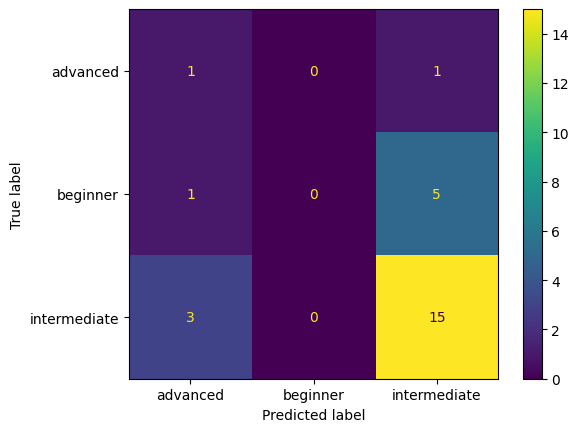

In [ ]:
print("Training of model:")
print()
model = Sequential([
    Dense(88, activation='relu'),
    Dense(3, activation=softmax)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_ff_tf-idf.weights.h5")

In [ ]:
model.summary()

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_290 (Dense)                    │ (None, 64)                  │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_291 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,699 (104.30 KB)

 Trainable params: 8,899 (34.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,800 (69.54 KB)

### 2. Topic classification

In [ ]:
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bows, targets, test_size=0.15, stratify=targets, shuffle=True)

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.60006196, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.42447722, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.32533478, 0.        , 0.        , 0.        , 0.     

In [ ]:
oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

#### 1. Feedforward network

Training of model:

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.0944 - loss: 2.1880 - val_accuracy: 0.1842 - val_loss: 2.1499
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2046 - loss: 2.1454 - val_accuracy: 0.2632 - val_loss: 2.1409
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3623 - loss: 2.1128 - val_accuracy: 0.2632 - val_loss: 2.1311
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5321 - loss: 2.0808 - val_accuracy: 0.2632 - val_loss: 2.1215
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6529 - loss: 2.0476 - val_accuracy: 0.2632 - val_loss: 2.1087
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7449 - loss: 2.0065 - val_accuracy: 0.2632 - val_loss: 2.0947
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7972 - loss: 1.9677 - val_accuracy: 0.2632 - val_loss: 2.0856
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8192 - loss: 1.9168 - val_accuracy: 0.2632

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


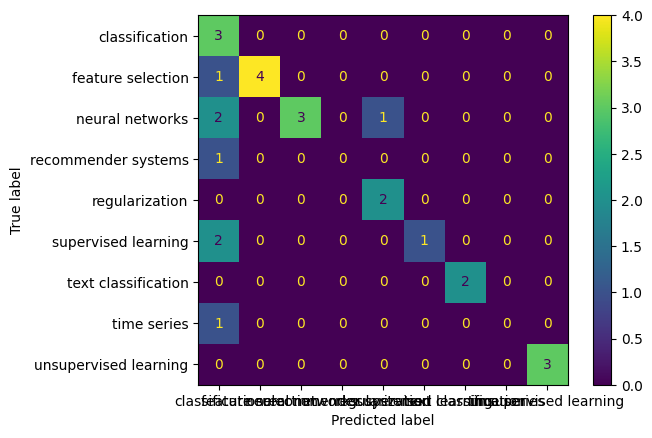

In [ ]:
print("Training of model:")
print()
model = Sequential([
    Dense(64, activation='relu'),
    Dense(9, activation=softmax)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_ff_tf-idf.weights.h5")

In [ ]:
model.summary()

Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_362 (Dense)                    │ (None, 64)                  │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_363 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,869 (108.87 KB)

 Trainable params: 9,289 (36.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,580 (72.58 KB)

# 2. Difficulty extended dataset

In [ ]:
data_path = "dataset_extended_difficulty.csv"
df = pd.read_csv(data_path)
df

,question,difficulty
0,Which feature selection techniques do you know?,intermediate
1,What is a time series?,beginner
2,Which hyper-parameter tuning strategies (in ge...,intermediate
3,How can we use CNN model for text classification?,advanced
4,How to predict the best time series?,beginner
...,...,...
375,What are the different types of machine learni...,beginner
376,Is accuracy always a good metric?,beginner
377,"If you have a sentence with multiple words, yo...",intermediate
378,Can you tell us more about how you would use X...,advanced


In [ ]:
df["difficulty"].value_counts()

,count
difficulty,
intermediate,140
beginner,120
advanced,120


In [ ]:
print("Total:", len(df), ", Intermediate:", len(df[df['difficulty'] == 'intermediate']), ", Advanced:", len(df[df['difficulty'] == 'advanced']), ", Beginner:", len(df[df['difficulty'] == 'beginner']))
print("Total:", 100*(len(df)/len(df)), "%, Intermediate:", 100*(len(df[df['difficulty'] == 'intermediate'])/len(df)), "%, Advanced:", 100*(len(df[df['difficulty'] == 'advanced'])/len(df)), "%, Beginner:", 100*(len(df[df['difficulty'] == 'beginner'])/len(df)), "%")

Total: 380 , Intermediate: 140 , Advanced: 120 , Beginner: 120
Total: 100.0 %, Intermediate: 36.84210526315789 %, Advanced: 31.57894736842105 %, Beginner: 31.57894736842105 %


## 1. Tensorflow tokenizer

In [ ]:
corpus = [elm for elm in df.loc[:, 'question']]
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
max_len = max(len(sequence) for sequence in sequences)
sequences = pad_sequences(sequences, padding='post', maxlen=max_len)

targets = [elm for elm in df.loc[:, 'difficulty']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(sequences, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

print("Original data: advanced: " + str(len([x for x in y_train if x[0] == 1])) + ", beginner: " + str(len([x for x in y_train if x[1] == 1])) + ", intermediate: " + str(len([x for x in y_train if x[2] == 1])))
print("Oversampled data: advanced: " + str(len([x for x in yTrain_oversampled if x[0] == 1])) + ", beginner: " + str(len([x for x in yTrain_oversampled if x[1] == 1])) + ", intermediate: " + str(len([x for x in yTrain_oversampled if x[2] == 1])))

Original data: advanced: 102, beginner: 102, intermediate: 119
Oversampled data: advanced: 119, beginner: 119, intermediate: 119


### 1. LSTM

Training of model: 

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.3416 - loss: 1.1000 - val_accuracy: 0.1296 - val_loss: 1.1161
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3556 - loss: 1.0981 - val_accuracy: 0.1296 - val_loss: 1.1235
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3698 - loss: 1.0964 - val_accuracy: 0.1296 - val_loss: 1.1342
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3716 - loss: 1.0941 - val_accuracy: 0.1296 - val_loss: 1.1148
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4199 - loss: 1.0465 - val_accuracy: 0.4444 - val_loss: 1.0108
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5418 - loss: 0.8897 - val_accuracy: 0.5000 - val_loss: 0.8869
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5952 - loss: 0.7912 - val_accuracy: 0.7778 - val_loss: 0.7033
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8204 - loss: 0.4972 - val

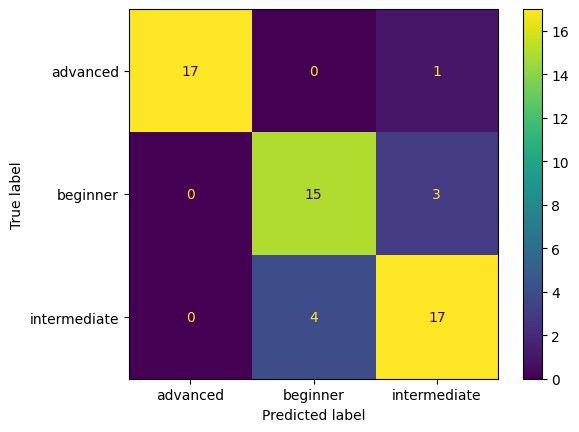

In [ ]:
model = Sequential([
    Embedding(5000, 64),
    LSTM(units=100, dropout=0.1),
    Dense(64, activation='relu'),
    Dense(3, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_extended_lstm.weights.h5")

In [ ]:
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)             │ (None, 34, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,177,979 (4.49 MB)

 Trainable params: 392,659 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 785,320 (3.00 MB)

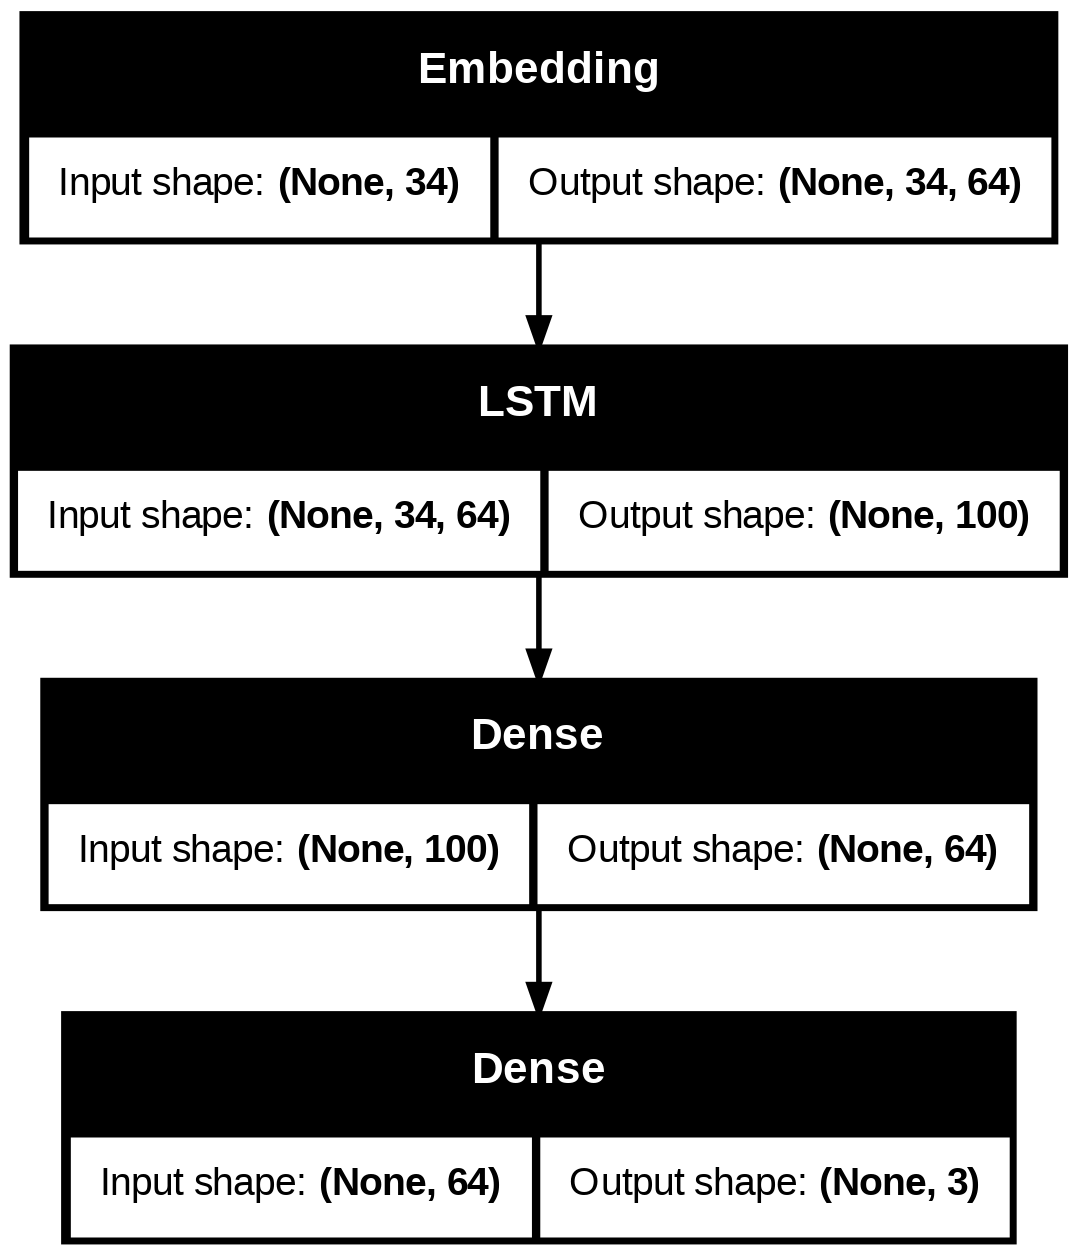

In [ ]:
plot_model(model, show_shapes=True)

### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(5000, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(3, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model: 

Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.4355 - loss: 1.1247 - val_accuracy: 0.6296 - val_loss: 0.9381
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.5645 - loss: 0.8731 - val_accuracy: 0.5185 - val_loss: 0.8886
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6781 - loss: 0.7143 - val_accuracy: 0.8704 - val_loss: 0.4801
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8553 - loss: 0.4484 - val_accuracy: 0.9259 - val_loss: 0.2459
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9620 - loss: 0.1610 - val_accuracy: 0.8889 - val_loss: 0.1949
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9874 - loss: 0.0504 - val_accuracy: 0.9630 - val_loss: 0.1698

Prediction on test set
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step

Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.84

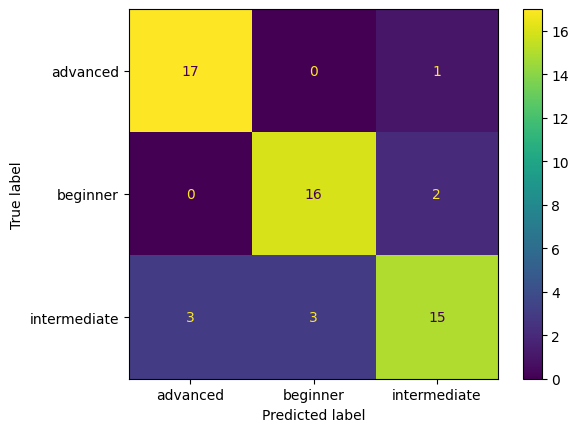

In [ ]:
print("Training of model: ")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=6, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_extended_transformer.weights.h5")

In [ ]:
model.summary()

Model: "transformer_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 34, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_6               │ (None, 34, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_6                │ (None, 34, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_6 (Add)                          │ (None, 34, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 34, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,610,495 (6.14 MB)

 Trainable params: 536,831 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,073,664 (4.10 MB)

## 2. Keyword tokenizer

In [ ]:
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions):
            for caption in captions:
                words = nltk.word_tokenize(caption.lower())
                for word in words:
                    self.add_word(WordNetLemmatizer().lemmatize(word))

vocab = Vocabulary()
vocab.build_vocabulary(list(df['question']))
VOCAB_SIZE = len(vocab.word2idx)

word_occurrence = {}
for idx in range(vocab.idx):
    word_occurrence[vocab.idx2word[idx]] = 0

i = 0
for caption in list(df['question']):
    words = nltk.word_tokenize(caption.lower())
    for word in words:
        new_word = WordNetLemmatizer().lemmatize(word)
        word_occurrence[new_word] = word_occurrence[new_word] + 1

word_occurrence_no_stopwords = {}
for k, v in word_occurrence.items():
    if any(c.isalpha() for c in k) and len(k) > 1 and k not in stopwords.words('english'):
      word_occurrence_no_stopwords[k] = v

sorted_tokens = sorted(word_occurrence_no_stopwords.items(), key=lambda x: x[1], reverse=True)
sorted_tokens = [('<PAD>', 0)] + sorted_tokens

word2idx = {}
idx2word = {}
idx = 0
with open("keywords.txt") as file:
    #for word, occurence in sorted_tokens:
    for line in file:
        line = line.rstrip()
        word = line.split(' ')[0]
        word2idx[word] = idx
        idx2word[idx] = word
        idx = idx + 1

key_vectors = []
vec_len = 10
for text in list(df['question']):
  vec_rep = []
  words = nltk.word_tokenize(text.lower())
  keywords = []
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        keywords.append(new_word)
        vec_rep.append(word2idx[new_word])
  if len(vec_rep) >= vec_len:
    vec_rep = vec_rep[:vec_len]
  else:
    vec_rep = vec_rep + [0 for x in range(vec_len - len(vec_rep))]

  vec_rep = np.array(vec_rep)
  key_vectors.append(vec_rep)
key_vectors = np.array(key_vectors)

print(key_vectors)
print()

targets = [elm for elm in df.loc[:, 'difficulty']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(key_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

print("Original data: advanced: " + str(len([x for x in y_train if x[0] == 1])) + ", beginner: " + str(len([x for x in y_train if x[1] == 1])) + ", intermediate: " + str(len([x for x in y_train if x[2] == 1])))
print("Oversampled data: advanced: " + str(len([x for x in yTrain_oversampled if x[0] == 1])) + ", beginner: " + str(len([x for x in yTrain_oversampled if x[1] == 1])) + ", intermediate: " + str(len([x for x in yTrain_oversampled if x[2] == 1])))

[[  9  34  19 ...   0   0   0]
 [ 29  22   0 ...   0   0   0]
 [148  60  88 ...   0   0   0]
 ...
 [179  16  16 ...   0   0   0]
 [146 147  38 ...   0   0   0]
 [  4   6   0 ...   0   0   0]]

Original data: advanced: 102, beginner: 102, intermediate: 119
Oversampled data: advanced: 119, beginner: 119, intermediate: 119


### 1. LSTM

Training of model: 

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.4017 - loss: 1.0988 - val_accuracy: 0.1111 - val_loss: 1.1105
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3739 - loss: 1.0904 - val_accuracy: 0.4444 - val_loss: 1.0800
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5625 - loss: 1.0381 - val_accuracy: 0.8148 - val_loss: 0.8242
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6435 - loss: 0.7763 - val_accuracy: 0.8704 - val_loss: 0.4624
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7601 - loss: 0.6174 - val_accuracy: 0.8889 - val_loss: 0.4472
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8997 - loss: 0.3608 - val_accuracy: 0.8704 - val_loss: 0.3434
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9362 - loss: 0.2355 - val_accuracy: 0.9259 - val_loss: 0.3750
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9081 - loss: 0.2419 - va

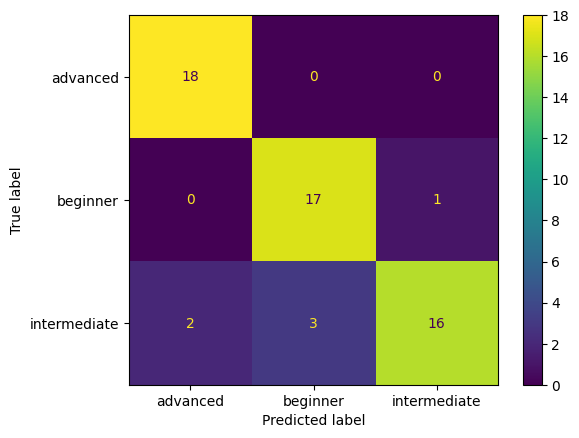

In [ ]:
model = Sequential([
    Embedding(200, 64),
    LSTM(units=100, dropout=0.1),
    Dense(64, activation='relu'),
    Dense(3, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_extended_lstm_keyword.weights.h5")

In [ ]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 10, 64)              │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,379 (1001.48 KB)

 Trainable params: 85,459 (333.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 170,920 (667.66 KB)

### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(200, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(3, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model: 

Epoch 1/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.4158 - loss: 1.1018 - val_accuracy: 0.7963 - val_loss: 0.7975
Epoch 2/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7426 - loss: 0.7709 - val_accuracy: 0.8889 - val_loss: 0.6086
Epoch 3/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8759 - loss: 0.5607 - val_accuracy: 0.9074 - val_loss: 0.3868
Epoch 4/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9046 - loss: 0.3574 - val_accuracy: 0.9259 - val_loss: 0.2727
Epoch 5/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9280 - loss: 0.2192 - val_accuracy: 0.9630 - val_loss: 0.1597
Epoch 6/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9774 - loss: 0.1110 - val_accuracy: 0.8889 - val_loss: 0.2279
Epoch 7/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9531 - loss: 0.1015 - val_accuracy: 0.9630 - val_loss: 0.1105

Prediction on test set
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step

Classification report: 
       

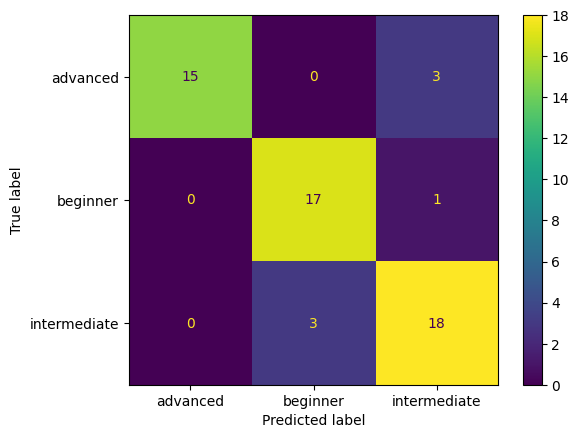

In [ ]:
print("Training of model: ")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=7, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_extended_transformer_keyword.weights.h5")

In [ ]:
model.summary()

Model: "transformer_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)             │ (None, 10, 100)             │          20,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_17              │ (None, 10, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_17               │ (None, 10, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_17 (Add)                         │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_36 (Sequential)           │ (None, 10, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,495 (666.00 KB)

 Trainable params: 56,831 (222.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,664 (444.00 KB)

## 3. Bag of words from keywords

In [ ]:
bag_vectors = []
for text in list(df['question']):
  bag_vec = [0 for x in word2idx]
  words = nltk.word_tokenize(text.lower())
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        bag_vec[word2idx[new_word]] = bag_vec[word2idx[new_word]] + 1
  bag_vec = np.array(bag_vec)
  bag_vectors.append(bag_vec)
bag_vectors = np.array(bag_vectors)
print(bag_vectors.shape)
print(bag_vectors)
print()
targets = [elm for elm in df.loc[:, 'difficulty']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(bag_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

print("Original data: advanced: " + str(len([x for x in y_train if x[0] == 1])) + ", beginner: " + str(len([x for x in y_train if x[1] == 1])) + ", intermediate: " + str(len([x for x in y_train if x[2] == 1])))
print("Oversampled data: advanced: " + str(len([x for x in yTrain_oversampled if x[0] == 1])) + ", beginner: " + str(len([x for x in yTrain_oversampled if x[1] == 1])) + ", intermediate: " + str(len([x for x in yTrain_oversampled if x[2] == 1])))

(380, 198)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Original data: advanced: 102, beginner: 102, intermediate: 119
Oversampled data: advanced: 119, beginner: 119, intermediate: 119


In [ ]:
bag_vectors[11]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 1. Feedforward network

Training of model: 

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2821 - loss: 1.1144 - val_accuracy: 0.4259 - val_loss: 1.0908
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5082 - loss: 1.0475 - val_accuracy: 0.5185 - val_loss: 1.0489
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6694 - loss: 0.9987 - val_accuracy: 0.6852 - val_loss: 1.0076
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7802 - loss: 0.9533 - val_accuracy: 0.7407 - val_loss: 0.9592
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8072 - loss: 0.9055 - val_accuracy: 0.7222 - val_loss: 0.9093
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8140 - loss: 0.8472 - val_accuracy: 0.7222 - val_loss: 0.8622
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8023 - loss: 0.7959 - val_accuracy: 0.7407 - val_loss: 0.8126
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8131 - loss: 0.7270 - val

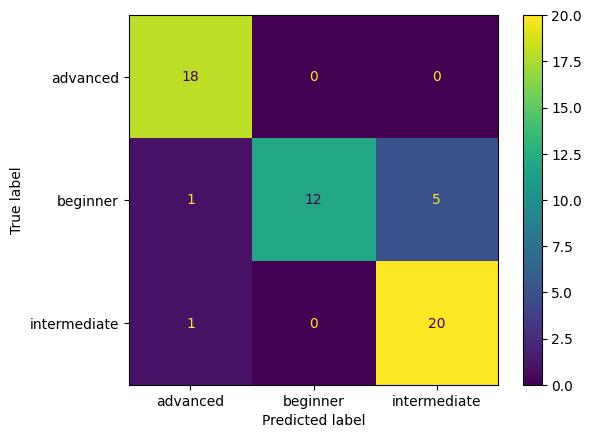

In [ ]:
model = Sequential([
    Dense(64, activation='relu'),
    Dense(3, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_extended_ff_bow.weights.h5")

In [ ]:
model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_128 (Dense)                    │ (None, 64)                  │          12,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,795 (151.55 KB)

 Trainable params: 12,931 (50.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,864 (101.04 KB)

## 4. TF-IDF

In [ ]:
num_of_features = 5000
corpus = [elm for elm in df.loc[:, 'question']]
corpus = [doc.lower() for doc in corpus]

class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=2, max_features=num_of_features, stop_words='english')
bows = tfidf_vectorizer_stemming.fit_transform(corpus)

targets = [elm for elm in df.loc[:, 'difficulty']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(bows, targets, stratify=targets, test_size=0.15)

X_train = X_train.toarray()
X_test = X_test.toarray()
print(bows)
print(X_train[0])
print()

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

print("Original data: advanced: " + str(len([x for x in y_train if x[0] == 1])) + ", beginner: " + str(len([x for x in y_train if x[1] == 1])) + ", intermediate: " + str(len([x for x in y_train if x[2] == 1])))
print("Oversampled data: advanced: " + str(len([x for x in yTrain_oversampled if x[0] == 1])) + ", beginner: " + str(len([x for x in yTrain_oversampled if x[1] == 1])) + ", intermediate: " + str(len([x for x in yTrain_oversampled if x[2] == 1])))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1745 stored elements and shape (380, 187)>
  Coords	Values
  (0, 58)	0.45831932609103654
  (0, 133)	0.5059475151374679
  (0, 154)	0.6083027511451231
  (0, 78)	0.40488056289102636
  (1, 160)	0.7194361555376046
  (1, 135)	0.6945585778789802
  (2, 78)	0.2959758285570394
  (2, 165)	0.49975977004069405
  (2, 145)	0.547626410629367
  (2, 0)	0.4258777967563246
  (2, 1)	0.4258777967563246
  (3, 168)	0.3460818667441969
  (3, 31)	0.5721206487044991
  (3, 96)	0.4259039360430115
  (3, 158)	0.4440395555681217
  (3, 28)	0.4175404353960587
  (4, 160)	0.4880372494216149
  (4, 135)	0.4711612772045735
  (4, 117)	0.5195318537105977
  (4, 20)	0.5195318537105977
  (5, 98)	0.5252460624832306
  (5, 121)	0.5753115743462326
  (5, 61)	0.6270033223748672
  (6, 154)	0.5001863755736566
  (6, 96)	0.2753132967863381
  :	:
  (374, 56)	0.6868266229912141
  (374, 126)	0.5811144345364553
  (375, 96)	0.3110510740092361
  (375, 50)	0.38454411531220145
  (375, 8

### 1. Feedforward network

Training of model: 

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3416 - loss: 1.0997 - val_accuracy: 0.7037 - val_loss: 1.0523
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6974 - loss: 1.0504 - val_accuracy: 0.8148 - val_loss: 1.0155
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8322 - loss: 1.0121 - val_accuracy: 0.8704 - val_loss: 0.9753
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8767 - loss: 0.9671 - val_accuracy: 0.8704 - val_loss: 0.9298
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8941 - loss: 0.9168 - val_accuracy: 0.8704 - val_loss: 0.8737
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9347 - loss: 0.8608 - val_accuracy: 0.8704 - val_loss: 0.8078
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9346 - loss: 0.7892 - val_accuracy: 0.8519 - val_loss: 0.7358
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9098 - loss: 0.7366 - val

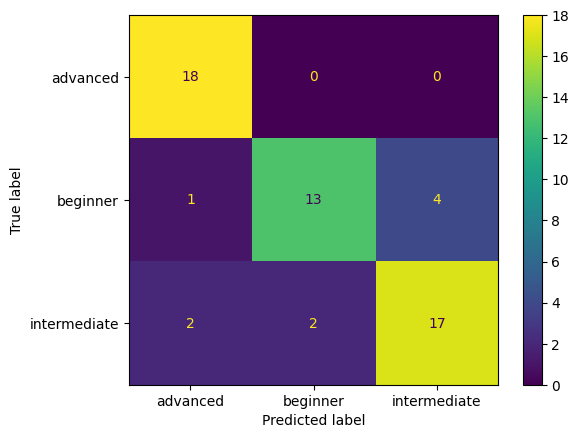

In [ ]:
model = Sequential([
    Dense(100, activation='relu'),
    Dense(3, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['advanced','beginner','intermediate'])
disp.plot()

In [ ]:
model.save_weights("difficulty_pred_model_extended_ff_tf-idf.weights.h5")

In [ ]:
model.summary()

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_136 (Dense)                    │ (None, 100)                 │          18,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,311 (223.88 KB)

 Trainable params: 19,103 (74.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,208 (149.25 KB)

# 3. Topic extended dataset

In [2]:
data_path = "dataset_extended_topic.csv"
df = pd.read_csv(data_path)
df

,question,topic
0,What is collaborative filtering?,recommender systems
1,What kind of CNN architectures for classificat...,neural networks
2,How can we deal with the imbalanced class dist...,supervised learning
3,What is time series and how it is different fr...,time series
4,What’s a convolutional layer?,neural networks
...,...,...
813,What do you mean by transfer learning?,unsupervised learning
814,What is Adam? What’s the main difference betwe...,neural networks
815,What is the difference between Logistic Regres...,classification
816,What are the common approaches to building an ...,recommender systems


In [3]:
df["topic"].value_counts()

,count
topic,
unsupervised learning,128
supervised learning,118
regularization,95
feature selection,95
recommender systems,86
classification,83
neural networks,71
time series,71
text classification,71


In [ ]:
name = []
per = []
for elm in df["topic"].unique():
  percent = int(df["topic"].value_counts()[elm])/len(df)
  name.append(elm)
  per.append(round(percent*100, 2))

df2 = pd.DataFrame()
df2['topic'] = name
df2['percentage'] = per
df2.sort_values('percentage', ascending=False)

,topic,percentage
4,unsupervised learning,15.65
2,supervised learning,14.43
6,regularization,11.61
5,feature selection,11.61
0,recommender systems,10.51
7,classification,10.15
1,neural networks,8.68
3,time series,8.68
8,text classification,8.68


## 1. Tensorflow tokenizer

In [ ]:
corpus = [elm for elm in df.loc[:, 'question']]
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
max_len = max(len(sequence) for sequence in sequences)
sequences = pad_sequences(sequences, padding='post', maxlen=max_len)

targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(sequences, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

### 1. LSTM

Training of model: 

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.1274 - loss: 2.1878 - val_accuracy: 0.0000e+00 - val_loss: 2.3555
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.1425 - loss: 2.1804 - val_accuracy: 0.0000e+00 - val_loss: 2.3841
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.1015 - loss: 2.1797 - val_accuracy: 0.0000e+00 - val_loss: 2.5591
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.2090 - loss: 1.9404 - val_accuracy: 0.2365 - val_loss: 1.8677
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.3130 - loss: 1.6709 - val_accuracy: 0.2635 - val_loss: 1.5065
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3686 - loss: 1.4595 - val_accuracy: 0.4324 - val_loss: 1.2295
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4679 - loss: 1.2132 - val_accuracy: 0.5743 - val_loss: 0.9769
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5608 - loss:

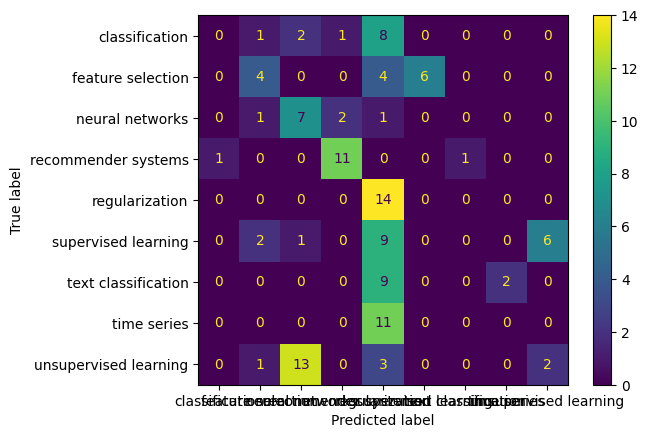

In [ ]:
model = Sequential([
    Embedding(5000, 100),
    LSTM(units=100, dropout=0.1),
    Dense(100, activation='relu'),
    Dense(9, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_extended_lstm.weights.h5")

In [ ]:
model.summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)             │ (None, 35, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 9)                   │             909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,774,229 (6.77 MB)

 Trainable params: 591,409 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,182,820 (4.51 MB)

### 2. Transformers

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(5000, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(9, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model: 

Epoch 1/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.1872 - loss: 2.2087 - val_accuracy: 0.2297 - val_loss: 1.9407
Epoch 2/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.3952 - loss: 1.7131 - val_accuracy: 0.8919 - val_loss: 0.6470
Epoch 3/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9193 - loss: 0.4742 - val_accuracy: 0.9865 - val_loss: 0.0849
Epoch 4/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9877 - loss: 0.0831 - val_accuracy: 0.9932 - val_loss: 0.0354
Epoch 5/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9891 - loss: 0.0494 - val_accuracy: 0.9932 - val_loss: 0.0176
Epoch 6/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9928 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 7/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9947 - loss: 0.0216 - val_accuracy: 0.9865 - val_loss: 0.0309

Prediction on test set
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step

Classification report: 
    

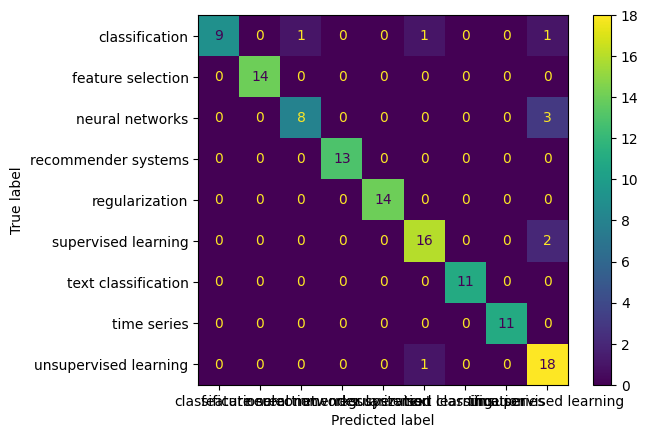

In [ ]:
print("Training of model: ")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=7, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_extended_transformer.weights.h5")

In [ ]:
model.summary()

Model: "transformer_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)             │ (None, 35, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_23              │ (None, 35, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_23               │ (None, 35, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_23 (Add)                         │ (None, 35, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_52 (Sequential)           │ (None, 35, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,611,665 (6.15 MB)

 Trainable params: 537,221 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,074,444 (4.10 MB)

## 2. Keywords tokenizer

In [ ]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions):
            for caption in captions:
                words = nltk.word_tokenize(caption.lower())
                for word in words:
                    self.add_word(WordNetLemmatizer().lemmatize(word))

vocab = Vocabulary()
vocab.build_vocabulary(list(df['question']))
VOCAB_SIZE = len(vocab.word2idx)

word_occurrence = {}
for idx in range(vocab.idx):
    word_occurrence[vocab.idx2word[idx]] = 0

i = 0
for caption in list(df['question']):
    words = nltk.word_tokenize(caption.lower())
    for word in words:
        new_word = WordNetLemmatizer().lemmatize(word)
        word_occurrence[new_word] = word_occurrence[new_word] + 1

word_occurrence_no_stopwords = {}
for k, v in word_occurrence.items():
    if any(c.isalpha() for c in k) and len(k) > 1 and k not in stopwords.words('english'):
      word_occurrence_no_stopwords[k] = v

sorted_tokens = sorted(word_occurrence_no_stopwords.items(), key=lambda x: x[1], reverse=True)
sorted_tokens = [('<PAD>', 0)] + sorted_tokens

word2idx = {}
idx2word = {}
idx = 0
with open("keywords.txt") as file:
    #for word, occurence in sorted_tokens:
    for line in file:
        line = line.rstrip()
        word = line.split(' ')[0]
        word2idx[word] = idx
        idx2word[idx] = word
        idx = idx + 1

key_vectors = []
vec_len = 10
for text in list(df['question']):
  vec_rep = []
  words = nltk.word_tokenize(text.lower())
  keywords = []
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        keywords.append(new_word)
        vec_rep.append(word2idx[new_word])
  if len(vec_rep) >= vec_len:
    vec_rep = vec_rep[:vec_len]
  else:
    vec_rep = vec_rep + [0 for x in range(vec_len - len(vec_rep))]

  vec_rep = np.array(vec_rep)
  key_vectors.append(vec_rep)
key_vectors = np.array(key_vectors)

print(key_vectors)
print()

targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(key_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

[[193 194   0 ...   0   0   0]
 [ 48  66   7 ...   0   0   0]
 [ 72  37  10 ...   0   0   0]
 ...
 [ 23  42   6 ...   0   0   0]
 [ 27 192  68 ...   0   0   0]
 [ 42   6   0 ...   0   0   0]]



### 1. LSTM

Training of model: 

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.1423 - loss: 2.1788 - val_accuracy: 0.0068 - val_loss: 2.3754
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3047 - loss: 1.8868 - val_accuracy: 0.1284 - val_loss: 2.0379
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3676 - loss: 1.3947 - val_accuracy: 0.6959 - val_loss: 0.8238
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7554 - loss: 0.7371 - val_accuracy: 0.9189 - val_loss: 0.3178
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8395 - loss: 0.4311 - val_accuracy: 0.9189 - val_loss: 0.2006
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9293 - loss: 0.2552 - val_accuracy: 0.9797 - val_loss: 0.0649
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9528 - loss: 0.1755 - val_accuracy: 0.9865 - val_loss: 0.0604
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9641 - loss: 0.1306 - val

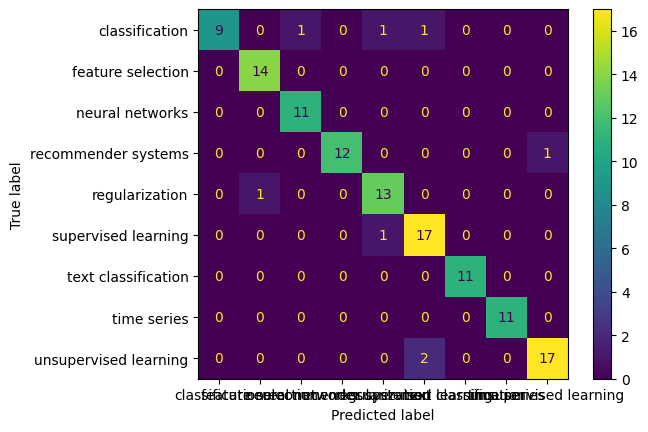

In [ ]:
model = Sequential([
    Embedding(200, 100),
    LSTM(units=100, dropout=0.1),
    Dense(100, activation='relu'),
    Dense(9, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_extended_lstm_keyword.weights.h5")

In [ ]:
model.summary()

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_51 (Embedding)             │ (None, 10, 100)             │          20,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 9)                   │             909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,229 (1.27 MB)

 Trainable params: 111,409 (435.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 222,820 (870.39 KB)

### 2. Transformer

In [ ]:
class Transformer(Model):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding(200, 100)
        self.multiheadattention = MultiHeadAttention(8, 3, value_dim=None, dropout=0.05)
        self.layernorm = LayerNormalization()
        self.add = Add()
        self.feedforward = Sequential([Dense(100, activation='relu'), Dense(100, activation='relu'), Dropout(0.1)])
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(9, activation=softmax)

    def call(self, inputs):
        x1 = self.embedding(inputs)
        attn_output = self.multiheadattention(x1, x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)
        x1 = self.feedforward(x1)
        x1 = self.add([x1, attn_output])
        x1 = self.layernorm(x1)

        x2 = self.embedding(inputs)
        attn_output = self.multiheadattention(x2, x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)
        x2 = self.feedforward(x2)
        x2 = self.add([x2, attn_output])
        x2 = self.layernorm(x2)

        attn_output = self.multiheadattention(x2, x1)
        x = self.add([x2, attn_output])
        x = self.layernorm(x)
        x = self.feedforward(x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        x = GlobalAveragePooling1D()(x)
        x = self.dense1(x)
        return self.dense2(x)

Training of model: 

Epoch 1/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.2923 - loss: 2.0794 - val_accuracy: 0.8581 - val_loss: 1.0438
Epoch 2/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8642 - loss: 0.8940 - val_accuracy: 0.9662 - val_loss: 0.1953
Epoch 3/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9471 - loss: 0.2178 - val_accuracy: 1.0000 - val_loss: 0.0353
Epoch 4/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9829 - loss: 0.0789 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 5/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9858 - loss: 0.0469 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 6/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9904 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 7/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9861 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 0.0046

Prediction on test set
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step

Classification report: 
     

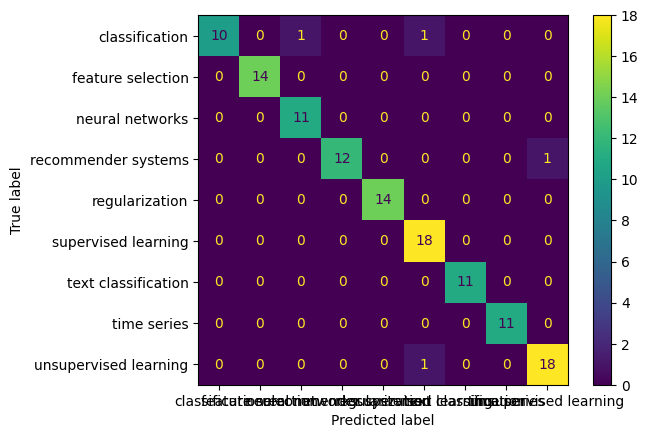

In [ ]:
print("Training of model: ")
print()
model = Transformer()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(xTrain_oversampled, yTrain_oversampled, epochs=7, validation_split=0.15)
print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_extended_transformer_keyword.weights.h5")

In [ ]:
model.summary()

Model: "transformer_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_55 (Embedding)             │ (None, 10, 100)             │          20,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_27              │ (None, 10, 100)             │           9,772 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_27               │ (None, 10, 100)             │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_27 (Add)                         │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_61 (Sequential)           │ (None, 10, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_179 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,665 (670.57 KB)

 Trainable params: 57,221 (223.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 114,444 (447.05 KB)

## 3. Bag of words from keywords

In [ ]:
bag_vectors = []
for text in list(df['question']):
  bag_vec = [0 for x in word2idx]
  words = nltk.word_tokenize(text.lower())
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        bag_vec[word2idx[new_word]] = bag_vec[word2idx[new_word]] + 1
  bag_vec = np.array(bag_vec)
  bag_vectors.append(bag_vec)
bag_vectors = np.array(bag_vectors)
print(bag_vectors.shape)
print(bag_vectors)
print(bag_vectors[10])
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(bag_vectors, targets, stratify=targets, test_size=0.15)

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

(818, 198)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 2 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### 1. Feedforward network

Training of model: 

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2619 - loss: 2.1266 - val_accuracy: 0.6959 - val_loss: 1.9123
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7051 - loss: 1.8219 - val_accuracy: 0.8784 - val_loss: 1.5838
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8527 - loss: 1.4841 - val_accuracy: 0.9527 - val_loss: 1.2026
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8822 - loss: 1.1478 - val_accuracy: 0.9527 - val_loss: 0.8522
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8795 - loss: 0.8700 - val_accuracy: 0.9595 - val_loss: 0.5404
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9079 - loss: 0.6405 - val_accuracy: 0.9662 - val_loss: 0.3728
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9276 - loss: 0.5092 - val_accuracy: 0.9797 - val_loss: 0.2675
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9619 - loss: 0.3969 - val_acc

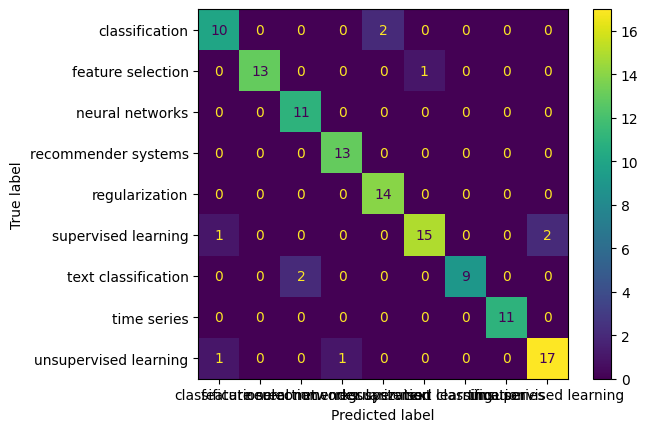

In [ ]:
model = Sequential([
    Dense(100, activation='relu'),
    Dense(9, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_extended_ff_bow.weights.h5")

In [ ]:
model.summary()

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_182 (Dense)                    │ (None, 100)                 │          19,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 9)                   │             909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,429 (243.87 KB)

 Trainable params: 20,809 (81.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,620 (162.58 KB)

## 4. TF-IDF

In [ ]:
num_of_features = 5000
corpus = [elm for elm in df.loc[:, 'question']]
corpus = [doc.lower() for doc in corpus]

class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=2, max_features=num_of_features, stop_words='english')
bows = tfidf_vectorizer_stemming.fit_transform(corpus)

targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
targets = to_categorical(ratings.codes)

X_train, X_test, y_train, y_test = train_test_split(bows, targets, stratify=targets, test_size=0.15)

X_train = X_train.toarray()
X_test = X_test.toarray()
print(bows)
print(X_train[0])
print()

oversampler = RandomOverSampler()
xTrain_oversampled, yTrain_oversampled = oversampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3780 stored elements and shape (818, 267)>
  Coords	Values
  (0, 53)	0.7071067811865476
  (0, 101)	0.7071067811865476
  (1, 126)	0.5164562933666869
  (1, 50)	0.4635446174902602
  (1, 20)	0.5518507350958343
  (1, 47)	0.29597676618438984
  (1, 127)	0.35532774264187383
  (2, 77)	0.4187505775971434
  (2, 116)	0.6098553863999562
  (2, 88)	0.5429883186592618
  (2, 138)	0.2974240045450106
  (2, 132)	0.26349005438728845
  (3, 236)	0.5371692419369867
  (3, 209)	0.526133663804956
  (3, 85)	0.39440432077167387
  (3, 193)	0.5282781512467188
  (4, 264)	0.44919510494013737
  (4, 202)	0.4522631180734572
  (4, 65)	0.5375112960370207
  (4, 131)	0.5520538346582654
  (5, 143)	0.4718581422408403
  (5, 173)	0.6584918394083613
  (5, 122)	0.5862920697345445
  (6, 156)	0.6828599524476401
  (6, 154)	0.7305493038414358
  :	:
  (812, 132)	0.28937863002290237
  (812, 85)	0.2725261879473797
  (812, 74)	0.4340828474529468
  (812, 89)	0.4799435388556187
 

### 1. Feedforward network

Training of model: 

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2552 - loss: 2.1702 - val_accuracy: 0.7973 - val_loss: 2.0154
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6962 - loss: 2.0255 - val_accuracy: 0.8716 - val_loss: 1.8603
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8271 - loss: 1.8394 - val_accuracy: 0.9257 - val_loss: 1.6473
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8548 - loss: 1.5994 - val_accuracy: 0.9324 - val_loss: 1.3728
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8773 - loss: 1.2767 - val_accuracy: 0.9392 - val_loss: 1.0665
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8939 - loss: 0.9832 - val_accuracy: 0.9459 - val_loss: 0.7697
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9114 - loss: 0.7577 - val_accuracy: 0.9392 - val_loss: 0.5682
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9126 - loss: 0.6137 - val_accura

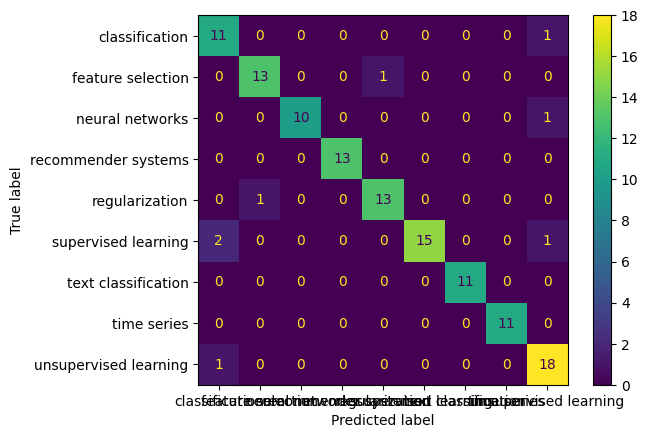

In [ ]:
model = Sequential([
    Dense(100, activation='relu'),
    Dense(9, activation=softmax)
])

print("Training of model: ")
print()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xTrain_oversampled, yTrain_oversampled, epochs=10, validation_split=0.15)

print()
print("Prediction on test set")
predicted = model.predict(X_test)

y = []
x = []
for i in range(len(predicted)):
  pred_list = np.ndarray.tolist(predicted[i])
  pred_ind = pred_list.index(max(pred_list))
  x.append(pred_ind)
  pred_list = np.ndarray.tolist(y_test[i])
  pred_ind = pred_list.index(max(pred_list))
  y.append(pred_ind)

print()
print("Classification report: ")
print(classification_report(y, x))
print("Balanced accuracy: ", balanced_accuracy_score(y, x))

print()
print("Confusion matrix: ")
cm = confusion_matrix(y, x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['classification','feature selection','neural networks','recommender systems','regularization','supervised learning','text classification','time series','unsupervised learning'])
disp.plot()

In [ ]:
model.save_weights("topic_pred_model_extended_ff_tf-idf.weights.h5")

In [ ]:
model.summary()

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_194 (Dense)                    │ (None, 100)                 │          26,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 9)                   │             909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,129 (324.73 KB)

 Trainable params: 27,709 (108.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,420 (216.49 KB)